# import libraries

In [5]:
#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from functools import reduce
import time
from backports import configparser
#
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess as lp
import LammpsPostProcess2nd as lpp
import utilityy as utll
import utility as utl
from utility import *
import imp
imp.reload(lp)
imp.reload(lpp)
imp.reload(utl)
imp.reload(utll)

<module 'utilityy' from '/Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/utilityy.py'>

# parsing configuration file

In [171]:
confParser = configparser.ConfigParser()

In [172]:
#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#--- set dynamic parameters
temp=confParser['parameters']['temperature']
load=confParser['parameters']['load']
confParser.set('input files','fileName',''.join([
               'Swapped_%s.dump '%temp,
               'equilibrium_%s.dump '%temp,
               'dump.shearedge5k_Sheng5_anealed_%sload '%load,
               'dump.shearedge5k_Sheng-non3_%sload '%load
              ]))


conf. file sections: ['parameters', 'flags', 'neigh list', 'input files', 'Atomic Radius']


In [173]:
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!


# Dump File

In [150]:
path = confParser['input files']['path']
indx = confParser['input files']['fileIndex']
fileName = confParser['input files']['filename'].split()[int(indx)]
#--- dump files
print('parsing %s/%s'%(path,fileName))
lmpData = lp.ReadDumpFile( '%s/%s'%(path,fileName) ) 
lmpData.GetCords( ncount = sys.maxsize, 
#                 columns = {'c_1[1]':'sxx','c_1[2]':'syy','c_1[3]':'szz',
#                                                   'c_1[4]':'sxy','c_1[5]':'sxz','c_1[6]':'syz'} 
#                  columns = {'c_mystress[1]':'sxx','c_mystress[2]':'syy','c_mystress[3]':'szz',
#                             'c_mystress[4]':'sxy','c_mystress[5]':'sxz','c_mystress[6]':'syz'}
                )
print('time steps:',lmpData.coord_atoms_broken.keys())
display(lmpData.coord_atoms_broken[0].head())


parsing /Users/Home/Desktop/Tmp/txt/git/HeaDef/lammpsRuns/AmirData/shengAnnealed/Temp600/dislocation-free/Run0//Swapped_600.dump
reached end of file!
time steps: dict_keys([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000])


,id,type,x,y,z
0,1,3,-0.847223,-0.715540,-0.931442
1,2,2,0.785225,0.834032,-0.677122
2,3,2,106.397000,0.892371,0.896775
3,4,2,0.873116,-0.891164,0.850165
4,5,2,2.700620,-0.836873,106.450000


In [151]:
def AddRndStrs(df):
    df['sxx']=np.random.normal(size=len(df))
    df['syy']=np.random.normal(size=len(df))
    df['szz']=np.random.normal(size=len(df))

#--- add random stress
list( map(lambda x:AddRndStrs(lmpData.coord_atoms_broken[x]),lmpData.coord_atoms_broken.keys()) )


[None, None, None, None, None, None, None, None, None, None, None]

## stress response

In [72]:
def GetStrsStrain( lmpData, col='sxy' ):

    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'TimeStep',fontsize=16)
    ax.set_ylabel(r'$%s$(Gpa)'%col,fontsize=16)
    ax.tick_params(labelsize=16)
    #
    #--- point corresponding to strain maps
    Box = {}
    strainDump = []
    Virial = []
    times = lmpData.coord_atoms_broken.keys()
    for itimee in sorted(times):

        #--- extract atom and box properties
        atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
        #
        Box[itimee] = lp.Box( BoxBounds = lmpData.BoxBounds[itimee], AddMissing = np.array([0.0,0.0,0.0] ))
        #
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0], AddMissing = np.array([0.0,0.0,0.0] ) ) #--- reference state

        #--- volume
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( Box[itimee].CellVector )
        volume = np.linalg.det( CellVectorOrtho )

        #--- virial stress
        try: 
            virial = np.sum(atoms[col]) / volume
        except: #--- dump file has no stress entry! 
            if col == 'p':
                virial = -(np.sum(atoms['sxx'])+np.sum(atoms['syy'])+np.sum(atoms['szz'])) / 3.0 / volume
            ReadStrsFromDump = False

        #--- bulk strain
        dx=Box[itimee].CellVector[0,1]-box0.CellVector[0,1]
        l1=Box[itimee].CellVector[1,1]
        ebulk = dx/l1    

        #--- append
        strainDump += [ebulk]
        Virial += [virial*1e-4] #--- bar to gpa 

            #
    ax.plot(
            sorted(times),
            Virial, '-')
    #
    plt.savefig('stress.png',dpi=75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    #

    
if eval(confParser['flags']['StrsCurve']):
    GetStrsStrain( lmpData,
                  col='sxy',
                 )


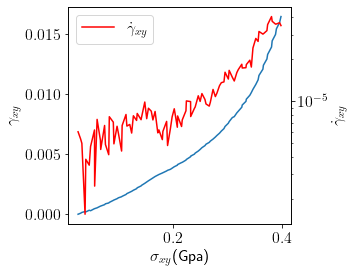

In [14]:
def GetStrsStrain( lmpData, col='sxy' ):

    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax2=ax.twinx()
    #
    ax.set_xlabel(r'$\sigma_{xy}$(Gpa)',fontsize=16)
    ax2.set_ylabel(r'$\dot\gamma_{xy}$',fontsize=16)
    ax.set_ylabel(r'$\gamma_{xy}$',fontsize=16)
    #
    ax2.set_yscale('log')
    #
    ax.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    #
    #--- point corresponding to strain maps
    Box = {}
    strainDump = []
    Virial = []
    times = lmpData.coord_atoms_broken.keys()
    for itimee in sorted(times):

        #--- extract atom and box properties
        atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
        #
        Box[itimee] = lp.Box( BoxBounds = lmpData.BoxBounds[itimee], AddMissing = np.array([0.0,0.0,0.0] ))
        #
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0], AddMissing = np.array([0.0,0.0,0.0] ) ) #--- reference state

        #--- volume
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( Box[itimee].CellVector )
        volume = np.linalg.det( CellVectorOrtho )

        #--- virial stress
        try: 
            virial = np.sum(atoms[col]) / volume
        except: #--- dump file has no stress entry! 
            if col == 'p':
                virial = -(np.sum(atoms['sxx'])+np.sum(atoms['syy'])+np.sum(atoms['szz'])) / 3.0 / volume
            ReadStrsFromDump = False
    #        virial = -(np.sum(atoms.sxx)+np.sum(atoms.syy)+np.sum(atoms.szz)) / 3.0 / volume

        #--- bulk strain
        dx=Box[itimee].CellVector[0,1]-box0.CellVector[0,1]
        l1=Box[itimee].CellVector[1,1]
        ebulk = dx/l1    

        #--- append
        strainDump += [ebulk]
        Virial += [virial*1e-4] #--- bar to gpa 

            #
    ax.plot(
            sorted(Virial),
            strainDump, '-',label=r'$\gamma_{xy}$')
    ax2.plot(
            sorted(Virial),
            np.gradient(strainDump,sorted(times)), 
            '-',color='red',label=r'$\dot\gamma_{xy}$')
    #
    plt.legend(fontsize=16)
    #
    plt.savefig('stress.png',dpi=75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    #

if eval(confParser['flags']['StrsCurve']):
    GetStrsStrain( lmpData,
              col='sxy',
             )


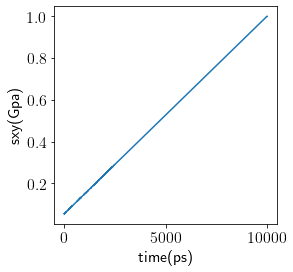

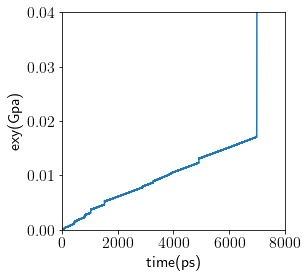

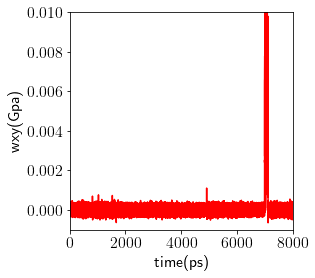

In [8]:
def GetStrsStrain( filee, xcol, ycol, **kwargs ):
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'%s(ps)'%xcol,fontsize=16)
    ax.set_ylabel(r'%s(Gpa)'%ycol,fontsize=16)
    #
    ax.tick_params(labelsize=16)
    #
    if 'xlim' in kwargs:
        ax.set_xlim(kwargs['xlim'])
    #
    if 'ylim' in kwargs:
        ax.set_ylim(kwargs['ylim'])
    #
    if 'xscale' in kwargs:
        ax.set_xscale(kwargs['xscale'])
    if 'yscale' in kwargs:
        ax.set_yscale(kwargs['yscale'])
    #
    df = pd.read_csv(filee,sep=' ')
    try:
        ax.plot(
                df[xcol],
                df[ycol], '-')
    except:
        if ycol == 'wxy':
            ax.plot(
                    df[xcol],
                    np.gradient(df['exy'],df['time']), 
                    '-',color='red',label=r'$\dot\gamma_{xy}$')
    #
    plt.savefig('stress.png',dpi=75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

if eval(confParser['flags']['StrsCurve']):

    GetStrsStrain( '%s/temperature.txt'%path,
                   xcol = 'time',
                   ycol = 'sxy',

                 )

    GetStrsStrain( '%s/temperature.txt'%path,
                   xcol = 'time',
                   ycol = 'exy',
                  xlim=np.array([0.0,.8])*10000,
                  ylim=[0.0,0.04]             
                 )

    GetStrsStrain( '%s/temperature.txt'%path,
                   xcol = 'time',
                   ycol = 'wxy',
                  xlim=np.array([0.0,0.8])*10000,
                  ylim=[-1e-3,1e-2],
                  xscale = 'linear', yscale = 'linear',
                 )

## parse data

In [73]:
#itimee=np.sum(list(lmpData.coord_atoms_broken.keys())) #--- only two timesteps:[0,ntime]
itimee=list(lmpData.coord_atoms_broken.keys())[-1] #--- only two timesteps:[0,ntime]
atomsRf = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='series') )
atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='series') )
    #
box = lp.Box( BoxBounds = lmpData.BoxBounds[itimee],AddMissing = np.array([0.0,0.0,0.0] ) )
#box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
    
display(pd.DataFrame(atoms.__dict__).head())
pd.DataFrame(atomsRf.__dict__).head()


,x,y,z,id,type,sxx,syy,szz
0,759.118,0.000024,130.658000,1,2,-1.357704,-1.937690,-1.789042
1,759.118,2.053570,2.748980,2,2,0.267779,0.197274,-0.254791
2,759.118,4.107130,1.281910,3,2,-0.176395,-1.471237,-0.523178
3,760.378,2.053570,0.621057,4,3,0.244517,-0.317857,0.456492
4,760.378,4.107130,3.475060,5,1,0.805389,0.239947,1.052140


,x,y,z,id,type,sxx,syy,szz
0,0.00000,0.00000,0.065458,1,2,-1.123136,-0.340794,-0.851273
1,0.00000,2.05355,2.844020,2,2,-1.780600,1.228752,1.590494
2,0.00000,4.10711,1.376950,3,2,-0.147734,-0.540406,1.601411
3,1.25962,2.05355,0.716095,4,3,0.144675,-0.449206,-0.448972
4,1.25962,4.10711,3.570100,5,1,-0.122598,-0.171723,-1.372653


## removed atom

In [10]:
# atom_id=np.sum(atomsRf.id)-np.sum(atoms.id)
# print('atom_id=',atom_id)
# zz=pd.DataFrame(atomsRf.__dict__)[pd.DataFrame(atomsRf.__dict__)['id']==atom_id]['z'].iloc[0]

In [11]:
# PrintOvito( pd.DataFrame(atomsDiff.__dict__), 
#             open( 'strsDiff.xyz','w'), 
#             footer = 'ITIME=%s'%itimee,
#             attr_list=['id','type','x','y','z','sxx' ,'syy' ,'szz' ,'sxy' ,'sxz' ,'syz'] )

# Displacements

In [74]:
if eval(confParser['flags']['Displ']):
    !ovitos OvitosCna.py $fileName Disp.xyz $nevery 4
    
#--- read from d2min.xyz
    ovtData = lp.ReadDumpFile( 'Disp.xyz' )
    ovtData.GetCords( ncount = sys.maxsize, 
                     columns = {'DisplacementX':'ux','DisplacementY':'uy','DisplacementZ':'uz'} )
    #
    disp = lp.Atoms( **ovtData.coord_atoms_broken[itimee].to_dict(orient='series'))


# Voronoi Analysis

In [165]:
if eval(confParser['flags']['VorAnl']):
    !mkdir voranl

    path = confParser['input files']['path']
    indx = confParser['input files']['fileIndex']
    fileName = '%s/%s'%(path,confParser['input files']['filename'].split()[int(indx)])
    nevery = int(confParser['parameters']['nevery'])

        
    rad1=0.0#AtomicRadius[1]
    rad2=0.0#AtomicRadius[2]
    rad3=0.0#AtomicRadius[3]
    !ovitos OvitosCna.py $fileName voranl/Voronoi.xyz $nevery 3 $rad1 $rad2 $rad3
    
#--- read from d2min.xyz
    ovtData = lp.ReadDumpFile( 'voranl/Voronoi.xyz' )
    ovtData.GetCords( ncount = sys.maxsize)

mkdir: voranl: File exists
InputFile= /Users/Home/Desktop/Tmp/txt/git/HeaDef/lammpsRuns/AmirData/shengAnnealed/Temp600/dislocation-free/Run0//Swapped_600.dump
num_frames= 11
frame=0
frame=2
frame=4
frame=6
frame=8
frame=10
reached end of file!


In [166]:
# plt.hist(atoms.AtomicVolume)

# Press. Fluc

In [167]:
!mkdir PressFluc

mkdir: PressFluc: File exists


In [169]:
def StrsDiff(atoms,atomsRf):
    atomsDiff = lp.Atoms( **pd.DataFrame(atoms.__dict__).copy().to_dict(orient='series'))
    atoms0 = lp.Atoms( **pd.DataFrame(atomsRf.__dict__).copy().to_dict(orient='series'))
    #--- virial energy to stress
    for key in ['sxx','syy','szz']:#,'sxy','syz','sxz']:
        atomsDiff.__dict__[key] /= atomsDiff['AtomicVolume']
        atoms0.__dict__[key] /= atoms0['AtomicVolume']
    df=pd.DataFrame(atoms0.__dict__).set_index('id').loc[atoms.id]
    #--- stress change
#    for key in ['sxx','syy','szz','sxy','syz','sxz','AtomicVolume']:
#        atomsDiff.__dict__[key] -= np.array((df[key]).tolist())
        
    #--- volumetric strain
#    atomsDiff.AtomicVolume /= atoms0.AtomicVolume
#    display(pd.DataFrame(atomsDiff.__dict__))
    return atomsDiff

if eval(confParser['flags']['PressFluc']):
    #--- fetch radii
    radii=list(map(float,confParser['Atomic Radius']['radius'].split()))
    types=list(map(int,confParser['Atomic Radius']['type'].split()))
    AtomicRadius=dict(zip(types,radii))
    #
    itime = 0
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series'),
                      rad = list(map(AtomicRadius.get,lmpData.coord_atoms_broken[itime]['type'])),
                       AtomicVolume = ovtData.coord_atoms_broken[itime]['AtomicVolume'].tolist(),
                    )
    #---
    atoms0 = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='series'),
                      rad = list(map(AtomicRadius.get,lmpData.coord_atoms_broken[0]['type'])),
                       AtomicVolume = ovtData.coord_atoms_broken[0]['AtomicVolume'].tolist(),
                    )

    display(pd.DataFrame(atoms.__dict__).head())
    
    #--- pressure change
    atomd=StrsDiff(atoms,atoms0) #--- atomd.sxx has units of stress 
    #--- filter abs(dv)>0
    atomd = lp.Atoms( **pd.DataFrame(atomd.__dict__)[np.abs(atomd.AtomicVolume)>1.0e-10].to_dict(orient='series'))
    display(pd.DataFrame(atomd.__dict__).head())

,x,y,z,id,type,sxx,syy,szz,AtomicVolume,rad
0,-0.847223,-0.715540,-0.931442,1,3,0.335510,-1.195055,-0.188390,11.548120,1.267
1,0.785225,0.834032,-0.677122,2,2,-1.059298,-0.272571,1.008550,11.282340,1.252
2,106.397000,0.892371,0.896775,3,2,-0.268324,-1.696617,1.478383,11.030720,1.252
3,0.873116,-0.891164,0.850165,4,2,-0.639861,-0.372906,-2.272357,11.088894,1.252
4,2.700620,-0.836873,106.450000,5,2,1.290503,1.519346,-0.900305,11.144316,1.252


,x,y,z,id,type,sxx,syy,szz,AtomicVolume,rad
0,-0.847223,-0.715540,-0.931442,1,3,0.029053,-0.103485,-0.016313,11.548120,1.267
1,0.785225,0.834032,-0.677122,2,2,-0.093890,-0.024159,0.089392,11.282340,1.252
2,106.397000,0.892371,0.896775,3,2,-0.024325,-0.153808,0.134024,11.030720,1.252
3,0.873116,-0.891164,0.850165,4,2,-0.057703,-0.033629,-0.204922,11.088894,1.252
4,2.700620,-0.836873,106.450000,5,2,0.115799,0.136334,-0.080786,11.144316,1.252


## Scatter plot

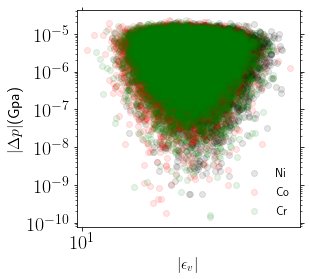

In [174]:
def PlotScatter(atomd,**kwargs):
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    if 'xlim' in kwargs:
        ax.axis(kwargs['xlim'])
    if 'Logy' in kwargs and kwargs['Logy']:
        ax.set_yscale('log')
    if 'Logx' in kwargs and kwargs['Logx']:
        ax.set_xscale('log')
    #
    ax.set_ylabel(kwargs['ylabel'] if 'ylabel' in kwargs else '',fontsize=16)
    ax.set_xlabel(kwargs['xlabel'] if 'xlabel' in kwargs else '',fontsize=16)

    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)

    y=np.array(atomd.sxx)+np.array(atomd.syy)+np.array(atomd.szz)
    y *= (-1.0e-4/3.0)
    x = np.array(atomd.AtomicVolume)
    
    cxy=0.0
    if 'zscore' in kwargs and kwargs['zscore']:
        x = Zscore(x)
        y = Zscore(y)
        cxy = np.sum(x*y)/len(x)
    for elm,indxx,col in zip(['Ni','Co','Cr'],[1,2,3],['black','red','green']):
        filtr = np.array(atomd.type) == indxx
        ax.scatter(np.abs(x[filtr]),np.abs(y[filtr]),
                   alpha=.1,c=col,label=elm)#,marker='x')
    #
    ax.legend(frameon=False, fontsize=12)
    #
#     DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    PutMinorTicks( ax, LOGY = True, LOGX=True)
    #
    plt.savefig('scatter.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

    return cxy
    
if eval(confParser['flags']['PressFluc']) and\
   eval(confParser['flags']['VorAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    
    #--- scatter plot of press and volumetric strain
    cxy = PlotScatter(atomd,
#               zscore = True,
#               xlim=[1e-7,1e-3,1e-8,1e4],
               Logx=True, Logy=True,
               ylabel = r'$|\Delta p|$(Gpa)',
               xlabel = r'$|\epsilon_v|$',
               )
    np.savetxt('PressFluc/PressVolCrltn.txt',[cxy],header='<p.v>')

## Mean pressure

In [175]:
if eval(confParser['flags']['PressFluc']):
    press=np.sum(np.array(atoms.sxx)+np.array(atoms.syy)+np.array(atoms.szz))
    vol = np.linalg.det(box.CellVector)
    press *= (-1.0e-4/3.0/vol)

    press0=np.sum(np.array(atoms0.sxx)+np.array(atoms0.syy)+np.array(atoms0.szz))
    vol = np.linalg.det(box.CellVector)
    press0 *= (-1.0e-4/3.0/vol)

    print('dp=',press-press0)
    np.savetxt('PressFluc/PressChange.txt',[press-press0],header='DeltaPress')


dp= 0.0


### multiple frames

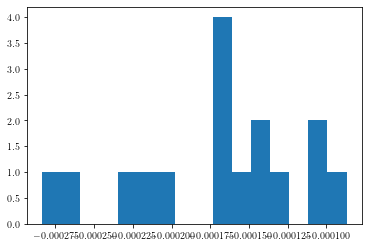

-0.00016933927094734172 0.3226011995601016


In [176]:
if not eval(confParser['flags']['RemoteMachine']):
    sarr = MultipleFrames2nd( path='NiCoCrNatom100KTakeOneOutRlxd', title='PressChange.txt', nrun = 16, ncols=1 ).flatten()

    plt.hist(sarr,bins=16)
    plt.show()
    
    print(sarr.mean(),sarr.std()/np.abs(sarr.mean()))

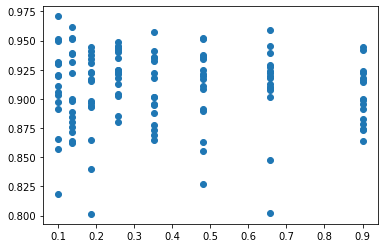

In [18]:
# fraci = np.logspace(np.log10(0.1),np.log10(0.9),8)
# for ifrac, fracc in zip(range(1000),fraci):
#     sarr  = MultipleFrames2nd(path='HeaNiCoCrNatom10KTakeOneOutFreezeFract%sRlxd'%ifrac,
#                               nrun=32,title='PressVolCrltn.txt',ncols=1).flatten()
#     indices = ~np.isnan( sarr )
#     sarr = sarr[ indices ]
#     plt.scatter([fracc]*len(sarr),-sarr,color='C0')
# plt.show()

## pressure decay

### map

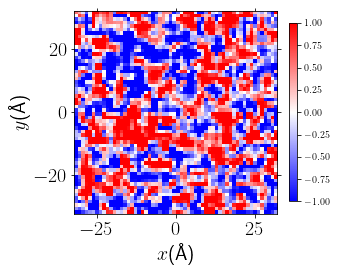

In [65]:
def Intrp( d2min, box0,times, time0, Plot = None ):
    #--- mean dist between atoms 
    natoms = len( d2min.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

    #--- expand the original box
        #--- map to square box
    mapp = lp.Map( d2min, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( d2min ) #--- atoms: add mapped xyz

    cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
    cptmp.Expand( epsilon = 0.3, mode = 'isotropic' )
    d2exp = cptmp.Get()

    points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
    values = np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0/np.array(d2exp.AtomicVolume)] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    d2intrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min']).to_dict(orient='list'))

    if Plot:
    #--- reshape value
        nx,ny,nz = len(xlin), len(ylin),len(zlin) 
        value = np.c_[d2intrp.d2min].reshape(((ny,nx,nz)))

        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
        #--- xy plane
        zz=0.5*(zlin[-1]+zlin[0])
        dz = zlin[-1]-zlin[-2]
        lz = zlin[-1]-zlin[0]
        nzz=int(nz*(zz-zlin[0])/lz)
        val = value[:,:,nzz].copy()
#        pdb.set_trace()

        np.savetxt('pressBitmap.txt',val)

        PltBitmap(val, 
                  xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                  zscore = True,
                  frac = 0.5, #--- plot a patch
                  title = 'd2min.png',
                  colorbar=True,
                )

    return (xlin, ylin, zlin), (xv[:,:,nzz], yv[:,:,nzz], zv[:,:,nzz]), d2intrp
  
if not eval(confParser['flags']['RemoteMachine']):
    junk, (xv, yv, zv), d2intrp = Intrp(atoms, box,
                    times = [0], #list(lmpData.coord_atoms_broken.keys()),
                    time0 =0,
                    Plot = True,
                   )

#### map and scatterd plot 

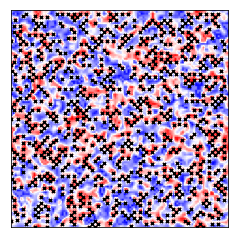

In [76]:
def PltBitmapWithScatter( value, xyScatter,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'cxy.png',
              colorbar=False,
              ticklabels=True,
              color='black',
              **kwargs
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    #
    aspect = (ylim[1]-ylim[0])/(xlim[1]-xlim[0])
    fig = plt.figure(figsize=(4,4*aspect))
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel,fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16)
    ax.tick_params(labelsize=16,which='both',axis='both', top=True, right=True)
    if not ticklabels:
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    #
    pos = ax.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
    
    ax.scatter(xyScatter[:,0],xyScatter[:,1],
           alpha=1,color=color,marker='x',s=10)
        
        
    if colorbar:
        ax.colorbar( pos, fraction = 0.04)
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'])
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    
def Intrp( d2min, box0,times, time0, title = 'bitmap', Plot = None ):
    d2intrp = {}
    for itime in times:
        #--- mean dist between atoms 
        natoms = len( d2min.x ) 
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
        volume = np.linalg.det( CellVectorOrtho )
        dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


        #--- grid tiling mapped box with original size
        #--- values are interpolated onto this grid
        (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                         box0.CellVector, 
                                                         dmean,
                                                         margin = 0.0 * dmean )
        xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

        #--- expand the original box
            #--- map to square box
        mapp = lp.Map( d2min, box0 ) 
        mapp.ChangeBasis()
        mapp.Set( d2min ) #--- atoms: add mapped xyz

        cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
        cptmp.Expand( epsilon = 0.2, mode = 'isotropic' )
        d2exp = cptmp.Get()

        points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
        values = np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0] #--- corresponding values

        grid_z = scp_int.griddata(points, values, xi, method='linear')
        assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

        #--- make an object
        d2intrp[ itime ] = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min']).to_dict(orient='list'))

        if Plot:
        #--- reshape value
            nx,ny,nz = len(xlin), len(ylin),len(zlin) 
            value = np.c_[d2intrp[ itime ].d2min].reshape(((ny,nx,nz)))

            CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
            #--- xy plane
#            zz=0.0
            zc=0.5*(zlin[0]+zlin[-1])
            dz = zlin[-1]-zlin[-2]
            lz = zlin[-1]-zlin[0]
            #
            zz = [zc,zlin[-1]][1]
            nzz=int(nz*(zz-zlin[0])/lz)
            if nzz == nz: nzz -= 1
            val = value[:,:,nzz].copy()
#            pdb.set_trace()
        
#            np.savetxt('pressBitmap.txt',val)

#             PltBitmap(val, 
#                       xlabel = 'x', ylabel = 'y',
#                       xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
#                       zscore = True,
#                       frac = 1.0, #--- plot a patch
#                  title = '%s%s.png'%(title,itime),
#                       colorbar=True,
#                     )
            
            #--- filter
            zlo=(zz-dz-zlin[0]) % lz + zlin[0]
            zhi=(zz+dz-zlin[0]) % lz + zlin[0]

            indxx= np.all([d2min.z > zlo, 
                           d2min.z < zhi
                          ],
                            axis=0)
            
            if zhi < zlo: #--- periodicity
                indxx= np.any([d2min.z > zlo, 
                               d2min.z < zhi
                              ],
                                axis=0)


            indices = d2min.type == 1 #--- Ni 3
            indxx = np.all([indxx,indices],axis=0)

            PltBitmapWithScatter(val, 
                  np.c_[np.array(d2min.x)[indxx],np.array(d2min.y)[indxx]],
                  xlabel = '', ylabel = '',
    #                  xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
                  xlim=np.array([xlin[0],xlin[-1]]),ylim=np.array([ylin[0],ylin[-1]]),
                  zscore = True,
                  frac = 1.0, #--- plot a patch
                  title = '%s%s.png'%(title,itime),
                  colorbar=None,
                  ticklabels = None,
                  color='black',
    #                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
                  )
                
                

    return (xlin, ylin, zlin), (xv[:,:,:], yv[:,:,:], zv[:,:,:]), d2intrp
  
if not eval(confParser['flags']['RemoteMachine']):
    #--- local pressure and Ni atoms
    junk, (xv, yv, zv), d2intrp = Intrp(atoms0, box,
                    times = [0], #list(lmpData.coord_atoms_broken.keys()),
                    time0 =0,
                    Plot = True,
                    title = 'cr',
                   )

#### average map

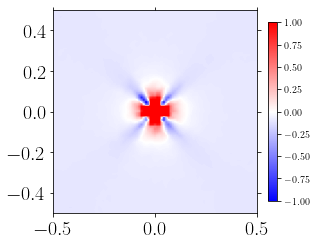

In [267]:
if not eval(confParser['flags']['RemoteMachine']):
    nruns=16
    for irun in range(nruns):
        val=np.loadtxt('NiCoCrNatom100KTakeOneOutRlxd/Run%s/pressBitmap.txt'%irun)
        if irun == 0:
            valm = val.copy()
        else:
            valm += val
    valm /= nruns

    PltBitmap(valm, 
              xlabel = '', ylabel = '',
    #          xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = 'd2min.png',
              colorbar=True,
    #          DrawFrame=[0.3,0.3,0.3,0.1,0.1],
            )

### scaling

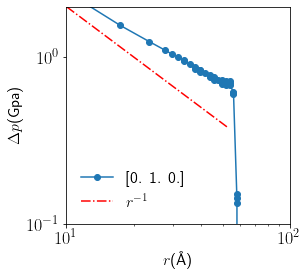

In [97]:
def GetCR( X, Y, Z, zfield, DIR, tol=1e-3, title='decay.png',**kwargs ):
    if 'xc' in kwargs:
        X = X.copy()
        Y = Y.copy()
        Z = Z.copy()
        xc = kwargs['xc']
        X -= xc[0]
        Y -= xc[1]
        Z -= xc[2]
    xyz = np.c_[X,Y,Z]
    xyzNorm = np.array(list(map(lambda x: np.sum(x)**.5,xyz*xyz)))
    #
    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.tick_params(labelsize=18)
    if 'Logy' in kwargs and kwargs['Logy']:
        ax.set_yscale('log')
    if 'Logx' in kwargs and kwargs['Logx']:
        ax.set_xscale('log')
    if 'xlim' in kwargs:
        ax.axis(kwargs['xlim'])
    ax.set_ylabel(kwargs['ylabel'] if 'ylabel' in kwargs else '',fontsize=16)
    ax.set_xlabel(kwargs['xlabel'] if 'xlabel' in kwargs else '',fontsize=16)
    #
    for ndir in DIR:
        dot = np.sum(xyz * ndir,axis=1) / np.sum(ndir*ndir)**0.5 / xyzNorm
        assert np.all([-1.0<=dot,dot<=1.0])
        #
        indices= np.abs(1.0-dot) < tol
        #
        xx=X[indices]
        yy=Y[indices]
        zz=Z[indices]
    #    print(np.c_[xx,yy,zz])
        #
        rr=np.sqrt(xx*xx+yy*yy+zz*zz)
        rho = zfield[indices]
        assert len( rr ) > 0 
        assert len(rho[np.isnan(rho)]) == 0
        #
        slist=list(zip(rr,rho))
        slist.sort()
        rr = [i[0] for i in slist]
        rho = [i[1] for i in slist]
        ax.plot(rr,rho,'-o',label=r'%s'%ndir)
#        print(np.c_[rr,rho])
    #
    #--- draw power law
    if 'alpha' in kwargs:
        alpha = kwargs['alpha']
        xx=ax.lines[0].get_data()[0]
        xx.sort()
        xx = np.array(xx)
        ax.plot(ax.axis()[0]*(xx/xx[0]),ax.axis()[3]*(xx[0]/xx)**alpha,'-.r',label='$r^{-%s}$'%alpha)
        #
        ax.legend(frameon=False, fontsize=16)
    #--- save
    if 'Logy' in kwargs and kwargs['Logy']:
        PutMinorTicks(ax, LOGY=True)
    if 'Logx' in kwargs and kwargs['Logx']:
        PutMinorTicks(ax, LOGX=True)
    #DrawFrame(ax, 0.3,0.3,0.3,0.1,0.1)
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

    
    
if not eval(confParser['flags']['RemoteMachine']):

    #--- decay of local pressure
    valm = -1.0e-4*(atoms.sxx+atoms.syy+atoms.szz)/atoms.AtomicVolume/3.0 #--- corresponding values
    GetCR( atoms.x, atoms.y, atoms.z, valm, 
    #      np.array([[1.0,1.0,0.0],[-1.0,1.0,0.0],[-1.0,-1.0,0.0],[1.0,-1.0,0.0]] ),
    #      np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[-1.0,0.0,0.0],[0.0,-1.0,0.0]] ),
          np.array([[0.0,1.0,0.0]]),#,[1.0,1.0,0.0]] ),
          xc=np.array([28.6,0.0,0.0]), #--- origin
          xlabel=r'$r$(\r{A})',
          ylabel =r'$\Delta p$(Gpa)',
          xlim=(1e1,1e2,1e-1,2),
           Logy = True,
           Logx = True,
          alpha=1,
         )






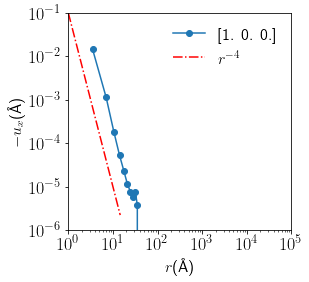

In [94]:
if not eval(confParser['flags']['RemoteMachine']):

    #--- decay of local pressure
    GetCR( disp.x, disp.y, disp.z, -disp.ux, 
          np.array([[1.0,0.0,0.0]]),
          xlabel=r'$r$(\r{A})',
          ylabel =r'$-u_x$(\r{A})',
          xlim=(1e0,1e5,1e-6,1e-1),
           Logy = True,
           Logx = True,
          alpha=4,
          title='udecay.png'
         )

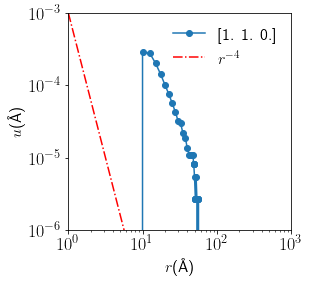

In [97]:
if not eval(confParser['flags']['RemoteMachine']):
    #--- decay of local pressure
    valm=list(map(lambda x: x[0]+x[1],np.c_[disp.ux,disp.uy,disp.uz]* np.array([[1.0,1.0,0.0]])/2**.5))
    GetCR( disp.x, disp.y, disp.z, np.array(valm), 
          np.array([[1.0,1.0,0.0]]),
          xlabel=r'$r$(\r{A})',
          ylabel =r'$u$(\r{A})',
          xlim=(1e0,1e3,1e-6,1e-3),
           Logy = True,
           Logx = True,
          alpha=4,
          title='udecay.png'
         )

## Composition Fluctuations


In [177]:
def plott(sarr,nx,ny,nz,box,zlin, title):
    value = np.c_[sarr].reshape(((ny,nx,nz)))
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    zz=0.5*(zlin[-1]+zlin[0])
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nzz=int(nz*(zz-zlin[0])/lz)
    val = value[:,:,nzz].copy()
    #        pdb.set_trace()
    PltBitmap(val, 
              xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = title,
              colorbar=True,
            )
    
    
def GetComp( atoms, atomf ):
    #--- different types
    types = set(atomf.type)
    c={}
    n = len(atoms.x)
    
    return dict(zip(types,list(map(lambda x:1.0*np.sum(atoms.type == x)/n,types))))
#    for typei in types:
#        c[typei] = 1.0*np.sum(atoms.type == typei)/n
#
#    return c


def GetPressComp( atoms,box, dmean, **kwargs ):
    #--- grid: tiling mapped box with original size
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box.CellOrigin, 
                                                     box.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean, odd = False )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))
    dvol = (xlin[1]-xlin[0])*(ylin[1]-ylin[0])*(zlin[1]-zlin[0])
    (ny,nx,nz) = xv.shape
    print(xv.shape)
#     nx -= 1
#     ny -= 1
#     nz -= 1
    assert nx*ny*nz >= 8, 'decrease division length!'
    #--- indices
    (xvi, yvi, zvi) = np.meshgrid(np.arange(0,nx),np.arange(0,ny),np.arange(0,nz))
    indices = np.array(list(zip(xvi.flatten(), yvi.flatten(), zvi.flatten()))) #--- shape:(ncel,3)
    indices = list(map(lambda x: tuple(x),indices))

    #--- partition box & assign index to each atom
    wrap = lp.Wrap(atoms,box)
    wrap.WrapCoord() #--- wrap inside
    wrap.Set(atoms)
    assert np.sum(wrap.isInside()) == len(atoms.x)
    wrap.GetDimensionlessCords()
    AtomCellId = (wrap.beta * np.array([nx,ny,nz])).astype(int)
    #--- store in a df
    df = pd.DataFrame(np.c_[pd.DataFrame(atoms.__dict__),AtomCellId],
                         columns=list(pd.DataFrame(atoms.__dict__).keys())+['ix','iy','iz'])
    df['ix']=df['ix'].astype(int)
    df['iy']=df['iy'].astype(int)
    df['iz']=df['iz'].astype(int)
#    display(df.head())

    #--- group & compute p and c
    d = df.groupby(by=['ix','iy','iz']).groups
#     print(len(d))
    if 'MODU' in kwargs and kwargs['MODU']:
        assert len(d) == nx*ny*nz, 'empty boxes!'
    #--- lambda function: compute p 
    f = lambda x: np.sum(np.sum(np.array(x.sxx)+np.array(x.syy)+np.array(x.szz)))*(-1.0e-4/3.0/dvol)
    vol=np.linalg.det(box.CellVector)
    #
    
    keys = indices if 'MODU' in kwargs and kwargs['MODU'] else d.keys()
#    pdb.set_trace()

    #--- subset of cells
    if 'ncmax' in kwargs:
        ncell = len(keys)
#        assert ncell == nx * ny * nz, '%s != %s'%(ncell,nx * ny * nz)
        keys = list(keys)[0:np.min([ncell,kwargs['ncmax']])]
    print('dmean=',dmean,len(keys))

    plist = np.zeros(len(keys)) #list(map(lambda x:f(df.iloc[d[x]]),keys)) #--- len(plist) = ncell
    clist = list(map(lambda x:GetComp(df.iloc[d[x]],atoms),keys)) #--- clist[icell]={1:c1,2:c2, ...}
    
    #---
    if 'PLOT' in kwargs and kwargs['PLOT']:
        plott(plist,nx,ny,nz,box,zlin, 'pCG.png')
    
    
    #--- read file: elastic constants
    if 'MODU' in kwargs and kwargs['MODU']:
        fileName = kwargs['PATH']
        modu = pd.read_csv(fileName, sep=' ',header=0)
#        display(modu.head())
        if 'PLOT' in kwargs and kwargs['PLOT']:
            plott(modu['C66'],nx,ny,nz,box,zlin, 'muCG.png')

    #--- plot
    #--- reshape value


        
#        display(modu.head())
    if 'MODU' in kwargs and kwargs['MODU']:
        mlist = modu['C66'].to_list()
        return clist, plist, mlist
    else:
        return clist, plist


### partition

In [180]:
if eval(confParser['flags']['PressFluc']):
    #--- length scales
    nn=[list(set(np.logspace(5,1,8,base=2,dtype=int))),
        list(set(np.logspace(6,1,32,base=2,dtype=int))),
        list(set(np.logspace(6,1,16,base=2,dtype=int)))
       ][ 1 ]
    nn.sort()

    #clist, plist = GetPressComp( atoms,box, 20.0 )
    #--- partition
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ) )

    rsub = np.array([
            [53.7],
            list(map(lambda x: box.CellVector[0,0]/x,nn))
           ][1])
    rsub = rsub[rsub>3.0] #--- r>r_nearest 
    print('rsub=',rsub)
    
    # #--- composition and pressure fluctuations
#    t0 = time.time()
    ncmax=1000
#    cplist = list(map(lambda x: GetPressComp( atoms,box, x, ncmax=ncmax ), rsub))
#    print('partitioning %s'%(time.time()-t0))



rsub= [53.7260776  35.81738506 26.8630388  21.49043104 17.90869253 15.35030788
 13.4315194  11.93912835 10.74521552  9.76837774  8.2655504   7.67515394
  6.7157597   5.96956418  5.37260776  4.67183283  4.1327752   3.70524673
  3.35787985]
(3, 3, 3)
dmean= 53.726077595715374 27
(4, 4, 4)
dmean= 35.81738506381025 64
(5, 5, 5)
dmean= 26.863038797857687 100
(6, 6, 6)
dmean= 21.49043103828615 100
(7, 7, 7)
dmean= 17.908692531905125 100
(8, 8, 8)
dmean= 15.350307884490107 100
(9, 9, 9)
dmean= 13.431519398928844 100
(10, 10, 10)
dmean= 11.939128354603417 100
(11, 11, 11)
dmean= 10.745215519143075 100
(12, 12, 12)
dmean= 9.768377744675522 100
(14, 14, 14)
dmean= 8.265550399340826 100
(15, 15, 15)
dmean= 7.675153942245053 100
(17, 17, 17)
dmean= 6.715759699464422 100
(19, 19, 19)
dmean= 5.9695641773017085 100
(21, 21, 21)
dmean= 5.372607759571538 100
(24, 24, 24)
dmean= 4.671832834410033 100
(27, 27, 27)
dmean= 4.132775199670413 100
(30, 30, 30)
dmean= 3.7052467307389914 100
(33, 33, 33)
dmean=

#### multiple realizations

In [182]:
if eval(confParser['flags']['PressFluc']):
    nevery = int(confParser['parameters']['nevery'])
    times = np.array(list(lmpData.coord_atoms_broken.keys()))
    times = times[ times > 0 ][::nevery] #--- equilibration
    #
    atoml = list(map( lambda x:lp.Atoms( **lmpData.coord_atoms_broken[x].to_dict(orient='series')), times))
    atomd = dict(zip(times,atoml)) #--- dict: key=time val=atom object
    #
    boxl = list(map(lambda x:lp.Box( BoxBounds = lmpData.BoxBounds[x], AddMissing = np.array([0.0,0.0,0.0] )), times ))
    boxd = dict(zip(times,boxl))
    #--- attributes for modulus calculatiuons
    args = {
             'PLOT': False,
    #          'MODU':True, 
    #          'PATH':'%s/ElasticConst.txt'%path
           }
    cplist = [list(map(lambda x: 
              GetPressComp(atomd[x],
                           boxd[x], 
                           y,
                           ncmax=ncmax,
                           PATH = '%s/git/HeaDef/lammpsRuns/NiCoCrNatom100KAnnealedT600Elastic%s/Run0/ElasticConst.txt'%(path,2), **args  ), 
                       times)) 
              for y, indxx in zip(rsub,range(len(rsub)))]
    t0 = time.time()
    cplist = dict(zip(rsub,cplist)) #--- dict: key=length val=cp list
    print('partitioning all timesteps: %s'%(time.time()-t0))


(3, 2, 2)
dmean= 53.726077595715374 12
(4, 3, 3)
dmean= 35.81738506381025 36
(5, 4, 4)
dmean= 26.863038797857687 80
(6, 5, 5)
dmean= 21.49043103828615 100
(7, 6, 6)
dmean= 17.908692531905125 100
(8, 7, 7)
dmean= 15.350307884490107 100
(9, 8, 8)
dmean= 13.431519398928844 100
(10, 9, 9)
dmean= 11.939128354603417 100
(11, 10, 10)
dmean= 10.745215519143075 100
(12, 11, 11)
dmean= 9.768377744675522 100
(14, 13, 13)
dmean= 8.265550399340826 100
(15, 14, 14)
dmean= 7.675153942245053 100
(17, 16, 16)
dmean= 6.715759699464422 100
(19, 18, 18)
dmean= 5.9695641773017085 100
(21, 20, 20)
dmean= 5.372607759571538 100
(24, 23, 23)
dmean= 4.671832834410033 100
(27, 26, 26)
dmean= 4.132775199670413 100
(30, 29, 29)
dmean= 3.7052467307389914 100
(33, 32, 32)
dmean= 3.357879849732211 100
partitioning all timesteps: 2.288818359375e-05


In [183]:
def Concat(cplist):
    cp={}
    for key in cplist:
#         pdb.set_trace()
        value = reduce(lambda x, y: x+y, list(map(lambda x:list(x[1]),cplist[key]))) #--- concat press.
        valc  = reduce(lambda x, y: x+y, list(map(lambda x:list(x[0]),cplist[key]))) #--- concat press.
        try:
            val2 = reduce(lambda x, y: x+y, list(map(lambda x:list(x[2]),cplist[key]))) #--- concat mu.
        except:
            pass
        try:
            cp[key]=[valc,value,val2]
        except:    
            cp[key]=[valc,value]
    return cp

if eval(confParser['flags']['PressFluc']):
    cpdic = Concat(cplist) #--- cpdic[key] = [c,p]

#### pdf

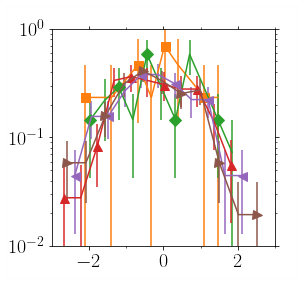

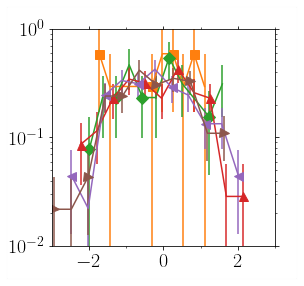

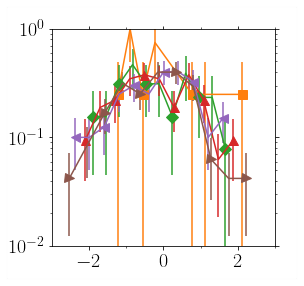

In [230]:
if eval(confParser['flags']['PressFluc']):
    #--- plots
    ax1=utl.PltErr(None,None,Plot=False)
    ax2=utl.PltErr(None,None,Plot=False)
    ax3=utl.PltErr(None,None,Plot=False)

    rs=list(cpdic.keys())
    nr=len(rs)

    ni_id=1
    co_id=2
    cr_id=3

    std1 = {}
    std2 = {}
    std3 = {}
    for r, indxx in zip(rs,range(0,nr,4)):
        std1[indxx] = list(map(lambda x:x[ni_id],cpdic[r][0]))
        std2[indxx] = list(map(lambda x:x[co_id],cpdic[r][0]))
        std3[indxx] = list(map(lambda x:x[cr_id],cpdic[r][0]))

    
        hist1, edges1, error1 = GetPDF( (std1[indxx]-np.mean(std1[indxx]))/np.std(std1[indxx]), 
                                     linscale = True, 
                                     n_per_decade=12,
                                     density = True,
                                                )
        hist2, edges2, error2 = GetPDF( (std2[indxx]-np.mean(std2[indxx]))/np.std(std2[indxx]), 
                                     linscale = True, 
                                     n_per_decade=12,
                                     density = True,
                                                )
        hist3, edges3, error3 = GetPDF( (std3[indxx]-np.mean(std3[indxx]))/np.std(std3[indxx]), 
                                     linscale = True, 
                                     n_per_decade=12,
                                     density = True,
                                                )
        ax1=utl.PltErr(edges1,hist1,
                       yerr=error1,
                        markevery=2,markersize=9,
                        yscale='log',
                        xscale='linear',
            #            xstr='r',
            #            ystr='Std./Mean',
                        Plot=False,
                        ax=ax1,
                        ylim=(1e-2,1e0),
                        xlim=(-3,3),
                        title='PressFluc/pdfNiLocalConcentration.png',
                        DrawFrame=[0.2,0.1,0.15,0.1,0.01],

              )
        ax2=utl.PltErr(edges2,hist2,
                       yerr=error2,
                        markevery=2,markersize=9,
                        yscale='log',
                        xscale='linear',
            #            xstr='r',
            #            ystr='Std./Mean',
                        Plot=False,
                        ax=ax2,
                        ylim=(1e-2,1e0),
                        xlim=(-3,3),
                        title='PressFluc/pdfCoLocalConcentration.png',
                        DrawFrame=[0.2,0.1,0.15,0.1,0.01],

              )
        ax3=utl.PltErr(edges3,hist3,
                       yerr=error3,
                        markevery=2,markersize=9,
                        yscale='log',
                        xscale='linear',
            #            xstr='r',
            #            ystr='Std./Mean',
                        Plot=False,
                        ax=ax3,
                        ylim=(1e-2,1e0),
                        xlim=(-3,3),
                        title='PressFluc/pdfCrLocalConcentration.png',
                        DrawFrame=[0.2,0.1,0.15,0.1,0.01],

              )


#### variance

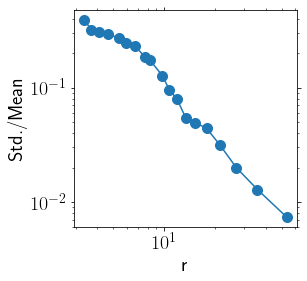

In [184]:
if eval(confParser['flags']['PressFluc']):
    rs=list(cpdic.keys())
    nr=len(rs)

    ni_id=1
    co_id=2
    cr_id=3

    std1 = np.zeros(nr)
    std2 = np.zeros(nr)
    std3 = np.zeros(nr)
    for r, indxx in zip(rs,range(nr)):
        std1[indxx] = np.std(list(map(lambda x:x[ni_id],cpdic[r][0])))
        std2[indxx] = np.std(list(map(lambda x:x[co_id],cpdic[r][0])))
        std3[indxx] = np.std(list(map(lambda x:x[cr_id],cpdic[r][0])))

    np.savetxt('PressFluc/concentration_r.txt',np.c_[rs,std1,std2,std3],header='r\tstdNi\tstdCo\tstdCr')
    PltErr(rs,std1,
        yscale='log',
        xscale='log',
        xstr='r',
        ystr='Std./Mean',
        title='PressFluc/var.png'

          )

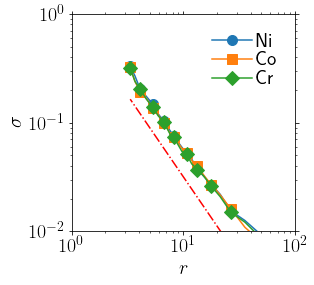

In [185]:
if eval(confParser['flags']['PressFluc']) and not\
   eval(confParser['flags']['RemoteMachine']):
    
    pathh = {1:'NiCoCrNatom100KTemp400sro/Run0',
             2:'NiCoCrNatom100KTemp800RhoFlucRss/Run0'
            }[2]
    rs,std1,std2,std3 = np.loadtxt('%s/PressFluc/concentration_r.txt'%pathh).T
    #
    ax=PltErr(rs,std1,
        Plot=False,
              markevery=2,
              label='Ni'
          )
    ax=PltErr(rs,std2,
        Plot=False,
        ax=ax,
              markevery=2,
              label='Co'
          )
    ax=PltErr(rs,std3,
        Plot=False,
        ax=ax,
              markevery=2,
              label='Cr'
          )
    PltErr(rs,1/rs**1.5,
          ax=ax,
           attrs={'fmt':'-.r'},
           xlim=(1,100),
           ylim=(1e-2,1),
        yscale='log',
        xscale='log',
        xstr='$r$',
        ystr=r'$\sigma$',
        title='PressFluc/var.png',
           Plot=True,
           legend=True
          )
    

### Plot
#### Separate

In [129]:
def ScatterPlt3d( clist, plist, 
                 Plot = True,
                 **kwargs ):
    xx = np.array(list(map(lambda x: x[1.0],clist)))
    #
    yy = np.array(list(map(lambda x: x[2.0],clist)))
    #
    zz = np.array(list(map(lambda x: x[3.0],clist))) #plist
    #--- linear fit
    reg = LinearRegression().fit(np.c_[xx,yy], zz)
#     pdb.set_trace()

    if 'zscore' in kwargs and kwargs['zscore']:
        xx = Zscore(xx)
        yy = Zscore(yy)
        zz = Zscore(zz) #plist)

    #--- plot
    if Plot:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111,projection='3d')
        #
        ax.set_xlabel(r'Ni',fontsize=18)
        ax.set_ylabel(r'Co',fontsize=18)
#        ax.set_zlabel(r'$p$',fontsize=18)
        ax.set_zlabel(r'Cr',fontsize=18)
        #
        ax.tick_params(labelsize=18)
        if 'zscore' in kwargs and kwargs['zscore']:
            sigma=3
            ax.set_xlim(-sigma,sigma)    
            ax.set_ylim(sigma,-sigma)
            ax.set_zlim(-sigma,sigma)
            ax.scatter(0,0,0,c='red')
        elif 'xlim' in kwargs:
            ax.axis(kwargs['xlim'][0:4])    
            ax.set_zlim(kwargs['xlim'][4:])
            ax.scatter(0.33,0.33,0.33,c='red')


        alpha=0.2
        #
        ax.scatter(xx,yy,zz,
                    alpha=alpha,

                  )

        #--- projection
        xflat = np.full_like(xx, min(ax.get_xlim()))
        yflat = np.full_like(yy, min(ax.get_ylim()))
        zflat = np.full_like(zz, min(ax.get_zlim()))
        #
        ax.scatter(xflat, yy, zz,c='black',alpha=alpha)
        ax.scatter(xx, yflat, zz,c='black',alpha=alpha)
        ax.scatter(xx, yy, zflat,c='black',alpha=alpha)
        #
        plt.savefig(kwargs['title'] if 'title' in kwargs else 'scatter.png',
                    dpi=150,bbox_inches='tight',pad_inches=0.0)
        plt.show()
    #
    return reg.coef_

if not eval(confParser['flags']['RemoteMachine']):

    # ScatterPlt3d( clist, plist, 
    # #               zscore = True, 
    #              xlim=[0.2,0.4,0.4,0.2],
    #                 Plot = True,
    #             )

    d=0.1
    coeffs = list(map(lambda x:
                                ScatterPlt3d( cpdic[x[0]][0], cpdic[x[0]][1], 
                                                zscore = False, 
                                              xlim=[0.33-d,.33+d,.33+d,.33-d,0.33-d,.33+d],
                                              Plot = True,
                                              title='scatter3d.%s.png'%(x[1]),
                                            ),    
                                zip(rsub,range(3))
                                ))

KeyError: 53.75271649167408

#### Projections

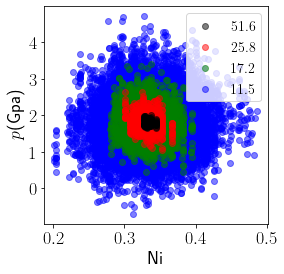

In [377]:
def ScatterPlt2d( clist, plist,
                 ax,
                 color,
                 zorder,
                 rsub=1.0,
                 typee=1.0,
                 Plot = True,
                 **kwargs ):
    xx = np.array(list(map(lambda x: x[typee],clist)))
    #
    zz = plist
    #--- linear fit

    if 'zscore' in kwargs and kwargs['zscore']:
        xx = Zscore(xx)
        zz = Zscore(plist)

    #--- plot
    if Plot:

        if 'zscore' in kwargs and kwargs['zscore']:
            sigma=3
            ax.set_xlim(-sigma,sigma)    
            ax.set_ylim(-sigma,sigma)
        elif 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])    
        alpha=.5
        ax.scatter(xx, zz,c=color,alpha=alpha,marker='o',
                   zorder=zorder, label='$%2.1f$'%rsub,
                  )

if not eval(confParser['flags']['RemoteMachine']):

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'Ni',fontsize=18)
    ax.set_ylabel(r'$p$(Gpa)',fontsize=18)
    #
    ax.tick_params(labelsize=18)
    #
    d=0.3
    dp=1.8
    list(map(lambda x:
            ScatterPlt2d( cpdic[x[0]][0],cpdic[x[0]][1],
    #                    x[0][0], x[0][1],
                         ax,
                         x[1],
                         x[2],
                         rsub=x[0],
                         typee=1.0,
    #                     zscore = True, 
    #                     xlim=[0.33-d,.33+d,1.8-dp,1.8+dp],
                          Plot = True,
                        ),    
    #        zip(cplist,['black','red','green','blue'],[4,3,2,1],[3600, 3800, 4000, 4200])
            zip(rsub,['black','red','green','blue','C0','orange'],[6,5,4,3,2,1])
            ))

    ax.legend(fontsize=14)
    plt.savefig('scatterNi.png',dpi=2*75,bbox_inches='tight')#,pad_inches=0.0)
    plt.show()


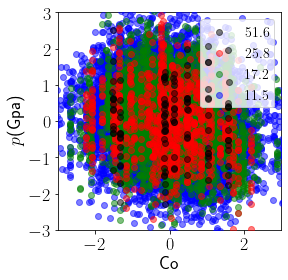

In [379]:
if not eval(confParser['flags']['RemoteMachine']):

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'Co',fontsize=18)
    ax.set_ylabel(r'$p$(Gpa)',fontsize=18)
    #
    ax.tick_params(labelsize=18)
    coeffs = list(map(lambda x:
            ScatterPlt2d( cpdic[x[0]][0],cpdic[x[0]][1],
    #                    x[0][0], x[0][1],
                         ax,
                         x[1],
                         x[2],
                         rsub=x[0],
                         typee=2.0,
                         zscore = True, 
    #                     xlim=[0.33-d,.33+d,1.8-dp,1.8+dp],
                          Plot = True,
                        ),    
    #        zip(cplist,['black','red','green','blue'],[4,3,2,1],[3600, 3800, 4000, 4200])
            zip(rsub,['black','red','green','blue','C0','orange'],[6,5,4,3,2,1])
                                ))
    ax.legend(fontsize=14)
    plt.savefig('scatterCo.png',dpi=2*75,bbox_inches='tight')#,pad_inches=0.0)
    plt.show()


#### altogether

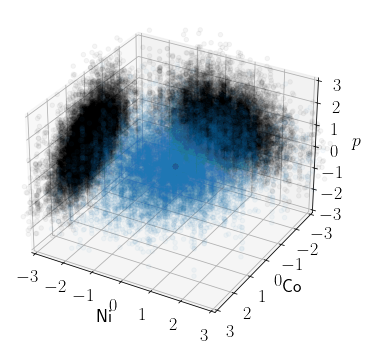

In [382]:
def ScatterPlt3d( clist, plist,
                 ax,
                 color,
                 zorder,
                 Plot = True,
                 **kwargs ):
    xx = np.array(list(map(lambda x: x[1.0],clist)))
    #
    yy = np.array(list(map(lambda x: x[2.0],clist)))
    #
    zz = plist
    #--- linear fit
    reg = LinearRegression().fit(np.c_[xx,yy], zz)
#     pdb.set_trace()

    if 'zscore' in kwargs and kwargs['zscore']:
        xx = Zscore(xx)
        yy = Zscore(yy)
        zz = Zscore(plist)

    #--- plot
    if Plot:

        if 'zscore' in kwargs and kwargs['zscore']:
            sigma=3
            ax.set_xlim(-sigma,sigma)    
            ax.set_ylim(sigma,-sigma)
            ax.set_zlim(-sigma,sigma)
            ax.scatter(0,0,0,c='red')
        elif 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])    
    #         ax.set_ylim(ax.axis()[3],ax.axis()[2])

        alpha=kwargs['alpha'] if 'alpha' in kwargs else .1
        #
        ax.scatter(xx,yy,zz,
                    alpha=alpha,
                   color='C0'

                  )

        #--- projection
        xflat = np.full_like(xx, min(ax.get_xlim()))
        yflat = np.full_like(yy, min(ax.get_ylim()))
        zflat = np.full_like(zz, min(ax.get_zlim()))
        
        ax.scatter(xflat, yy, zz,c=color,alpha=alpha,zorder=zorder)
        ax.scatter(xx, yflat, zz,c=color,alpha=alpha,zorder=zorder)
        #
    #
    return reg.coef_

if not eval(confParser['flags']['RemoteMachine']):

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111,projection='3d')
    #
    ax.set_xlabel(r'Ni',fontsize=18)
    ax.set_ylabel(r'Co',fontsize=18)
    ax.set_zlabel(r'$p$',fontsize=18)
    #
    ax.tick_params(labelsize=18)
    #
    #ax.set_title(r'$r=%s$ \r{A}, $T=%s^\circ K$'%(17,300),fontsize=18)
    #
    coeffs = list(map(lambda x:
                                ScatterPlt3d( cpdic[x[0]][0], cpdic[x[0]][1],
                                             ax,
                                             'black',#x[1],
                                             1,#x[2],
                                                zscore = True, 
    #                                          xlim=[0.2,0.4,0.4,0.2],
                                              Plot = True,
                                             alpha=0.04,
                                            ),    
                                zip(rsub,range(len(rsub)))
                                ))

    plt.savefig('scatter.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()


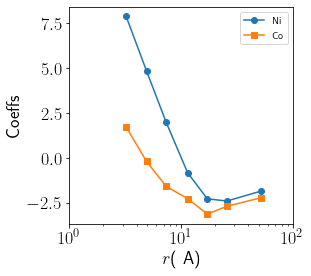

In [127]:
if not eval(confParser['flags']['RemoteMachine']):

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xscale('log')
    ax.set_xlim(1e0,1e2)
    ax.tick_params(labelsize=18)
    ax.set_xlabel('$r$(\r{A})',fontsize=18)
    ax.set_ylabel('Coeffs',fontsize=18)
    #
    ax.plot(rsub,np.array(coeffs)[:,0],'-o',label='Ni')
    ax.plot(rsub,np.array(coeffs)[:,1],'-s',label='Co')

    ax.legend()
    plt.show()

# Neighbor list

In [134]:
if eval(confParser['flags']['NeighList']):
    natoms = eval(confParser['neigh list']['natom']) #--- subset of atoms
    cutoff = eval(confParser['neigh list']['cutoff'])
    if eval(confParser['neigh list']['WritDisc']) and not eval(confParser['neigh list']['ReadDisc']):
        try:
            !rm neighList.xyz
        except:
            pass
        path = confParser['input files']['path']
        indx = confParser['input files']['fileIndex']
        fileName = '%s/%s'%(path,confParser['input files']['filename'].split()[int(indx)])
        nevery = int(confParser['parameters']['nevery'])
        t0=time.time()
        !ovitos OvitosCna.py $fileName neighList.xyz $nevery 4 $cutoff $natoms
        print('output neighbor list=%s s'%(time.time()-t0))


rm: neighList.xyz: No such file or directory
InputFile= /Users/Home/Desktop/Tmp/txt/git/HeaDef/lammpsRuns/AmirData/shengAnnealed/Temp600/dislocation-free/Run0//Swapped_600.dump
num_frames= 11
frame=0
frame=2
frame=4
frame=6
frame=8
frame=10
output neighbor list=13.982638120651245 s


In [135]:
if eval(confParser['flags']['NeighList']):
    t0=time.time()
    lmpNeigh = lp.ReadDumpFile( 'neighList.xyz' )
    lmpNeigh.GetCords( ncount = sys.maxsize)
    print('load neighbor list=%s s'%(time.time()-t0))
    print('times=',lmpNeigh.coord_atoms_broken.keys())
    display(lmpNeigh.coord_atoms_broken[0].head())

reached end of file!
load neighbor list=15.36129903793335 s
times= dict_keys([0, 10000, 20000, 30000, 40000, 50000])


,id,type,J,Jtype,DIST,DX,DY,DZ,PBC_SHIFT_X,PBC_SHIFT_Y,PBC_SHIFT_Z
0,1,3,3604.0,1.0,5.750882,1.560940,-0.047891,5.534782,0.0,0.0,0.0
1,1,3,7087.0,2.0,6.534448,3.274663,-1.852242,5.342732,0.0,-1.0,0.0
2,1,3,104283.0,3.0,5.545928,0.162128,-1.869247,-5.218903,0.0,-1.0,-1.0
3,1,3,104287.0,3.0,6.806679,3.526953,-1.951241,-5.484901,0.0,-1.0,-1.0
4,1,3,104284.0,1.0,6.682766,1.628320,-3.862244,-5.204903,0.0,-1.0,-1.0


# order parameter
## 2d map

In [136]:
!mkdir orderParameter

mkdir: orderParameter: File exists


In [137]:
def GridSize(box0, cutoff, dr):
    lx=2*cutoff #box0.CellVector[0,0]
    ly=2*cutoff #box0.CellVector[1,1]
    lz=2*cutoff #box0.CellVector[2,2]
    nx = int(lx/dr)
    ny = int(ly/dr)
    nz = int(lz/dr)
    if nx % 2 == 0:
        nx+=1
    if ny % 2 == 0:
        ny+=1
    if nz % 2 == 0:
        nz+=1
    print('grid size=',nx,ny,nz)
    return (ny,nx,nz), [(-0.5*ly,0.5*ly),(-0.5*lx,0.5*lx),(-0.5*lz,0.5*lz)]


def GetHistd(df, rangee, pair):
    (typei,typej) = pair
    print('pair=',pair)
    #--- filter
    indx = np.all([df.type==typei,df.Jtype==float(typej)], axis=0)
#    display(df[indx])
    #--- binning
    r = np.c_[df[indx][['DX','DY','DZ']]]
    H, edges = np.histogramdd(r, bins = (ny, nx, nz), range=rangee)
    print('H.shape=',H.shape) #, edges[0].size, edges[1].size, edges[2].size
#    assert not np.any(H == 0.0), 'increase bin size!'
    return H


def GetPairProb(df, pairs, rangee ):
#     pair=(2,2)
#     H = GetHistd(
#                     lmpNeigh.coord_atoms_broken[0],
#                     rangee,
#                     pair
#                 )

    H = list(map(lambda x: GetHistd( df, rangee, x),pairs))
    probt = reduce(lambda x, y: x+y, H ) #--- sum
    prob = map(lambda x:H[x]/probt,range(len(pairs)))

    return dict(zip(pairs,list(prob)))


## radial part
### RDF

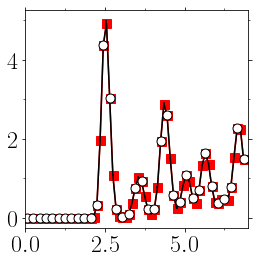

In [138]:
def Wrapper(lmpNeigh,lmpData,itime):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]


    rdf = lp.ComputeRdf(  atoms, box )
    rdf.PairCrltn(  
                  bins=np.arange(0.0,cutoff,0.1), 
                  rlist=neigh.DIST,
                  regular_r = True,
                  )
    return rdf.Get()


if eval(confParser['flags']['SroParameter']):
    itime=list(lmpNeigh.coord_atoms_broken.keys())[1]
    bin_edges1, hist1, err1 = Wrapper(lmpNeigh,lmpData,itime)
    bin_edges0, hist0, err0 = Wrapper(lmpNeigh,lmpData,0)
    #--- plot
    ax = PltErr(bin_edges1,hist1,err1,
          xlim=[0,cutoff],
            attrs={
                   'fmt':'-o',
                   'markersize':9,
                   'markevery':2,
                   'color':'black',
                   'markerfacecolor':'white',
                   'zorder':2,
                  },
                Plot=False,
#                xscale='log',
          )

    PltErr(bin_edges1,hist1,err1,
          xlim=[0,cutoff],
    #       ystr='$g(r)$',
    #       xstr='$r$',
           title='orderParameter/gr_sheng.png',
                    attrs={#'label':r'$\mathrm{without~annealing}$',
                           'fmt':'-s',
                           'markersize':9,
                           'markevery':1,
                           'color':'red',
                   'zorder':1,
                          },
                Plot=True,
           ax=ax,
    #        DrawFrame=[0.2,0.1,0.15,0.1,0.1],
           fontsize=24,
#                xscale='log',
          )

#### fit a spline

In [139]:
def ReturnShapeFunc(x,df):
    transformed_x = patsy.bs(x, df=df,degree =3, include_intercept=False)
    return transformed_x 

def TrainModel(x,y):
    reg = LinearRegression().fit(x, y )
    return reg
def Validate(reg, x,y,
             deg_f=np.arange(0,90,5), #np.logspace(0.0,8.0,9,base=2).astype(int),
             cv_samples=10):
    mse={}
    for df in deg_f:
#    for df in map(int,np.logspace(0,12,20,base=2,endpoint=True)):
        try:
            transfrm = ReturnShapeFunc(x,df)
            #--- vadidate    
            scores = cross_validate(reg,  transfrm, y, cv=cv_samples,
                                         scoring=('r2', 'neg_mean_squared_error'),
                                         return_train_score=True)
            mse[df] = np.mean(scores['train_neg_mean_squared_error'])
        except:
            continue
    return mse


# #--- training points
# transfrm = ReturnShapeFunc(bin_edges1,50)
    
# #--- train
# reg = TrainModel(transfrm,np.c_[hist1])

# #--- prediction
# y_pred = reg.predict( transfrm )


# #--- plot
# ax = PltErr(bin_edges1,hist1,err1,
#       xlim=[2,cutoff],
#         attrs={
#                'fmt':'o',
#                'color':'black',
#                'markerfacecolor':'white',
#                'zorder':1,
#               },
#             Plot=False
#       )

# PltErr(bin_edges1,y_pred,
#       xlim=[2,cutoff],
# #       ystr='$g(r)$',
# #       xstr='$r$',
# #       title='orderParameter/gr_sheng.png',
#                 attrs={#'label':r'$\mathrm{without~annealing}$',
#                        'fmt':'-',
#                        'markersize':9,
#                        'markevery':1,
#                        'color':'red',
#                'zorder':2,
#                       },
#             Plot=True,
#        ax=ax,
# #        DrawFrame=[0.2,0.1,0.15,0.1,0.1],
#        fontsize=24,
#       )

In [140]:
# mse = Validate(reg, bin_edges1,np.c_[hist1])
# try:
#     keys=mse.keys()
#     plt.scatter(keys, [-mse[key] for key in keys],marker='x')
#     plt.yscale('log')
# #    plt.xscale('log')
# #    plt.ylim(1e-5,1e-2)
# #    plt.savefig('cv.png',dpi=75,bbox_inches='tight')
#     plt.show()
# except:
#     pass

#### 2nd method

peaks of g(r) at:r= [2.51996097 3.57402319 4.37577777 5.06458198 5.65200988 6.20888196
 6.69782971]
valleys of g(r) at:r= [0.         3.08916817 3.95115396 4.75933965 5.32799911 6.00612618
 6.32348445]


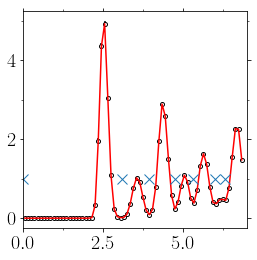

In [141]:
def quadratic_spline_roots(spl):
    roots = []
    knots = spl.get_knots()
    for a, b in zip(knots[:-1], knots[1:]):
        u, v, w = spl(a), spl((a+b)/2), spl(b)
        t = np.roots([u+w-2*v, w-u, 2*v])
        t = t[np.isreal(t) & (np.abs(t) <= 1)]
        roots.extend(t*(b-a)/2 + (b+a)/2)
    return np.array(roots)

from scipy.interpolate import InterpolatedUnivariateSpline

if eval(confParser['flags']['SroParameter']):
    r0=2.3
    y_axis=hist1
    x_axis=bin_edges1
    f = InterpolatedUnivariateSpline(x_axis, y_axis, k=4)
    
    ext=f.derivative().roots() #--- roots
    spl_dd=f.derivative().derivative()
    valleys=ext[np.all([spl_dd(ext)>0,ext>r0],axis=0)]
    peaks=ext[np.all([spl_dd(ext)<0,ext>r0],axis=0)]


#     cr_pts = quadratic_spline_roots(f.derivative())
#     cr_pts = np.append(cr_pts, (x_axis[0], x_axis[-1]))  # also check the endpoints of the interval
#     cr_pts = cr_pts[cr_pts>r0]
#     ddf=f.derivative().derivative()
#     peaks = np.sort(cr_pts[ddf(cr_pts)<0.0])
#     valleys = np.sort(cr_pts[ddf(cr_pts)>0.0])
    rpeak   = peaks[0]
    rvalley = valleys[0]
    if rvalley > rpeak:
        valleys = np.concatenate([np.array([0]),valleys])
    print('peaks of g(r) at:r=',peaks)
    print('valleys of g(r) at:r=',valleys)

    #--- plot
    ax = PltErr(bin_edges1,hist1,err1,
            attrs={
                   'fmt':'o',
                   'color':'black',
                   'markerfacecolor':'white',
                   'markersize':4,
                   'zorder':1,
                  },
                Plot=False
          )

    PltErr(x_axis,f(x_axis),
          xlim=[0,cutoff],
    #       ystr='$g(r)$',
    #       xstr='$r$',
    #       title='gr_sheng_T800K.png',
                    attrs={#'label':r'$\mathrm{without~annealing}$',
                           'fmt':'-',
                           'markersize':9,
                           'markevery':1,
                           'color':'red',
                   'zorder':2,
                          },
                Plot=False,
           ax=ax,
    #        DrawFrame=[0.2,0.1,0.15,0.1,0.1],
           fontsize=24,
          )
    
    PltErr(valleys,np.ones(len(valleys)),
           ax=ax,
           attrs={'fmt':'x','markersize':10}
          )
 

### WC order parameter

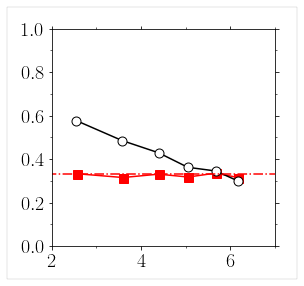

In [142]:
def Wrapper(itime,pairi,pairj,**kwargs):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]

    
    rdf = lp.ComputeRdf(  atoms, box )
    bins = np.arange(0.0,cutoff,0.1) if 'bins' not in kwargs else kwargs['bins']
    rdf.PairCrltn(  
                  bins=bins, 
                  rlist=neigh.DIST )
    return rdf.Sro(neigh,pairi,pairj,bins=bins)

    

if eval(confParser['flags']['SroParameter']):
    #---
    p0={}
    p1={}
    dp0={}
    dp1={}
    count = 0
    for pairi, pairj in [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]: #--- different elemental pairs
        bin_edges0, p0[count], dp0[count] = Wrapper(0,pairi,pairj,bins=valleys) #--- rss
        bin_edges1, p1[count], dp1[count] = Wrapper(itime,pairi,pairj,bins=valleys) #--- sro
        count += 1
        
    count = 0
    ax=    PltErr(bin_edges1,p1[count],yerr=dp1[count],
                Plot=False,
                attrs={#'label':r'$\mathrm{with~annealing}$',
                       'fmt':'-o',
                       'markersize':9,
                       'markevery':1,
                       'color':'black',
                       'markerfacecolor':'white',
                       'zorder':2,
                      },
              )
    
    ax = PltErr(bin_edges0,p0[count],yerr=dp0[count],
               ax=ax,
                Plot=False,
                attrs={#'label':r'$\mathrm{without~annealing}$',
                       'fmt':'-s',
                       'markersize':9,
                       'markevery':1,
                       'color':'red',
                       'zorder':1,
                      }
              )

    PltErr([0,cutoff],[0.33,0.33],
              xlim=[2,cutoff],
              ylim=[0,1],
               ax=ax,
               attrs={'fmt':'-.r'},
#               title='wc_%s%s_farkas_T800K.png'%(pairi,pairj),
#               ystr='$p_{%s%s}(r)$'%(pairi,pairj),
#               xstr='$r$',
#               legend=True,
#               fontsize=18,
           DrawFrame=[0.2,0.1,0.15,0.1,0.1],
              )

#### temporal fluctuations and mean

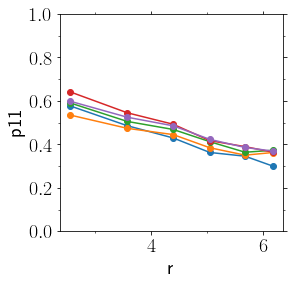

In [143]:
if eval(confParser['flags']['SroParameter']):
    times = list(lmpNeigh.coord_atoms_broken.keys()) #[itime] # #--- list of timesteps
    times.pop(0) #--- exclude 0
    #--- loop over pairs
    count = 0
    data = {}
    p1_mean = {}
    err_p1 = {}
    for pairi, pairj in [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]:
        data[count] = np.c_[list(map(lambda x:Wrapper(x,pairi,pairj,bins=valleys)[1],times))].T #--- data corresponding to different times
        p1_mean[count] = np.mean(data[count],axis=1) #--- mean
        err_p1[count] = ((np.mean(data[count]*data[count],axis=1) - p1_mean[count]*p1_mean[count])/len(times))**0.5

        #--- print
        np.savetxt('orderParameter/pr_annealed_ij_index%s.txt'%count,
                   np.c_[bin_edges1,p1_mean[count],err_p1[count]],
                   header='r\tp\terr_p')
        np.savetxt('orderParameter/pr_non_annealed_ij_index%s.txt'%count,
                   np.c_[bin_edges0,p0[count],dp0[count]],
                   header='r\tp\terr_p')
        count += 1
    #--- plot
    count = 0
    for indxx in range(data[count].shape[1]):
        kwargs={} if indxx == 0 else {'ax':ax}
        ax = PltErr(bin_edges1, data[count][:,indxx],
                    Plot=False,
                    xstr='r',
                    ystr='p11',
                    ylim=[0,1],
                    attrs={'fmt':'-o'},
                   **kwargs,
                  )

#### average

pair 1 1


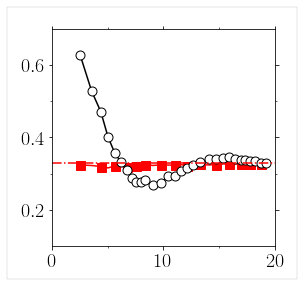

pair 1 2


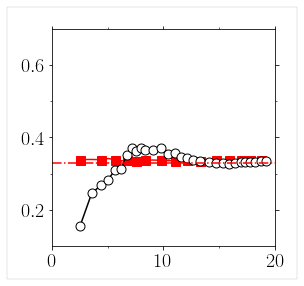

pair 1 3


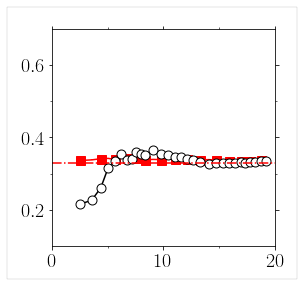

pair 2 2


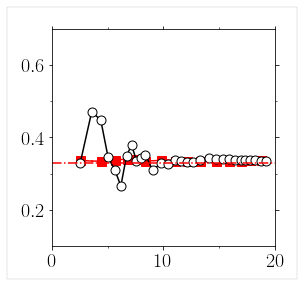

pair 2 3


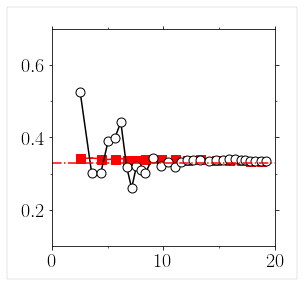

pair 3 3


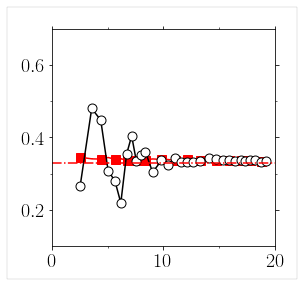

In [146]:
if eval(confParser['flags']['SroParameter']) and not\
   eval(confParser['flags']['RemoteMachine']):
    count = 0
    p0={}
    p1={}
    dp0={}
    dp1={}
    temp = 400
    pathh = 'NiCoCrNatom100KTemp%ssro/Run0'%temp
    p1_mean = {}
    err_p1 = {}
    for pairi, pairj in [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]:
        print('pair', pairi, pairj )
#         data[count] = np.c_[list(map(lambda x:Wrapper(x,pairi,pairj)[1],times))].T #--- data corresponding to different times
#         p1_mean[count] = np.mean(data[count],axis=1) #--- mean
#         err_p1[count] = ((np.mean(data[count]*data[count],axis=1) - p1_mean[count]*p1_mean[count])/len(times))**0.5

        #--- print
        bin_edges1,p1_mean[count],err_p1[count] = np.loadtxt('%s/orderParameter/pr_annealed_ij_index%s.txt'%(pathh,count)).T
        bin_edges0,p0[count],dp0[count] = np.loadtxt('%s/orderParameter/pr_non_annealed_ij_index%s.txt'%(pathh,count)).T
        
        
        #--- plot
        ax=    PltErr(bin_edges1,p1_mean[count],yerr=err_p1[count],
                    Plot=False,
                    attrs={#'label':r'$\mathrm{with~annealing}$',
                           'fmt':'-o',
                           'markersize':9,
                           'markevery':1,
                           'color':'black',
                           'markerfacecolor':'white',
                           'zorder':2,
                          },
                  )

        ax = PltErr(bin_edges0,p0[count],yerr=dp0[count],
                   ax=ax,
                    Plot=False,
                    attrs={#'label':r'$\mathrm{without~annealing}$',
                           'fmt':'-s',
                           'markersize':9,
                           'markevery':2,
                           'color':'red',
                           'zorder':1,
                          }
                  )

        PltErr([0,cutoff],[0.33,0.33],
                  xlim=[0,cutoff],
                  ylim=[0.1,.7],
                   ax=ax,
                   attrs={'fmt':'-.r'},
                   title='orderParameter/wc_%s%s_sheng.png'%(pairi,pairj),
        #               ystr='$p_{%s%s}(r)$'%(pairi,pairj),
        #               xstr='$r$',
        #               legend=True,
        #               fontsize=18,
               DrawFrame=[0.2,0.1,0.15,0.1,0.1],
                  )
        count += 1

In [101]:
#RemoteMachine=False

#### difference

pair 1 1


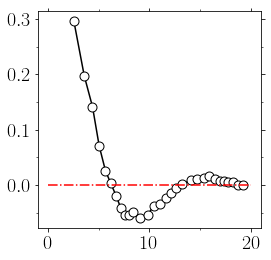

sro size= 6.7000101124152645
pair 1 2


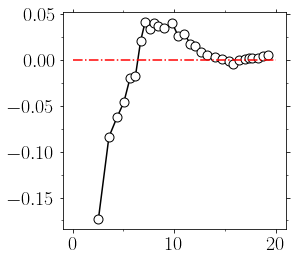

sro size= 2.535383823149344
pair 1 3


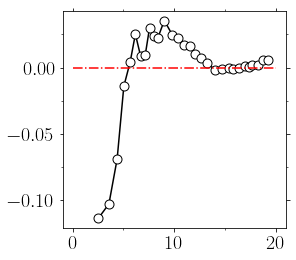

sro size= 2.535383823149344
pair 2 2


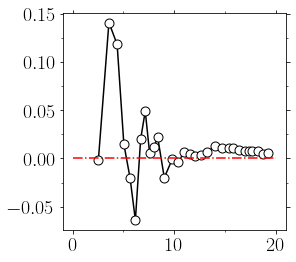

sro size= 2.535383823149344
pair 2 3


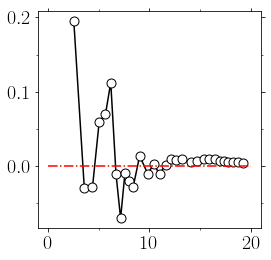

sro size= 3.572187992625973
pair 3 3


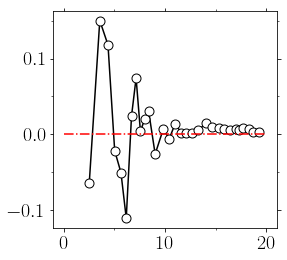

sro size= 2.535383823149344


In [102]:
if eval(confParser['flags']['SroParameter']) and not\
   eval(confParser['flags']['RemoteMachine']):
    count = 0
    for pairi, pairj in [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]:
        print('pair',pairi,pairj)
        p0[count] = 0.33 #--- equi-molar 
        ax=PltErr(bin_edges1,p1_mean[count]-p0[count],
                        Plot=False,
                        attrs={#'label':r'$\mathrm{with~annealing}$',
                               'fmt':'-o',
                               'markersize':9,
                               'markevery':1,
                               'color':'black',
                               'markerfacecolor':'white',
                               'zorder':2,
                              },
                      )
        
        PltErr([0,cutoff],[0.0,0.0],
 #         xlim=[0,cutoff],
 #         ylim=[0.1,.7],
           ax=ax,
           attrs={'fmt':'-.r'},
#           title='orderParameter/wc_%s%s_sheng.png'%(pairi,pairj),
#               ystr='$p_{%s%s}(r)$'%(pairi,pairj),
#               xstr='$r$',
#               legend=True,
#               fontsize=18,
#       DrawFrame=[0.2,0.1,0.15,0.1,0.1],
          )
        filtr = np.all([~np.isnan(p1_mean[count]-p0[count]),bin_edges1>rpeak],axis=0)
        val=(p1_mean[count]-p0[count])[filtr]
        r_sro = bin_edges1[filtr][val<0.0][0]
        print('sro size=',r_sro)
        np.savetxt('%s/orderParameter/sroSize_ij_index%s.txt'%(pathh,count),np.c_[temp,r_sro],header='temp\tsize')
        np.savetxt('%s/orderParameter/deltap_r_ij_index%s.txt'%(pathh,count),np.c_[bin_edges1,p1_mean[count]-p0[count]],header='r\tdp')
        count += 1


#### multiple Temperature

parse from /Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/NiCoCrNatom100KTemp400sro/Run0/orderParameter/deltap_r_ij_index0.txt
parse from /Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/NiCoCrNatom100KTemp600sro/Run0/orderParameter/deltap_r_ij_index0.txt
parse from /Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/NiCoCrNatom100KTemp800sro/Run0/orderParameter/deltap_r_ij_index0.txt
parse from /Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/NiCoCrNatom100KTemp1000sro/Run0/orderParameter/deltap_r_ij_index0.txt
parse from /Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/NiCoCrNatom100KTemp1200sro/Run0/orderParameter/deltap_r_ij_index0.txt
parse from /Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/NiCoCrNatom100KTemp1400sro/Run0/orderParameter/deltap_r_ij_index0.txt


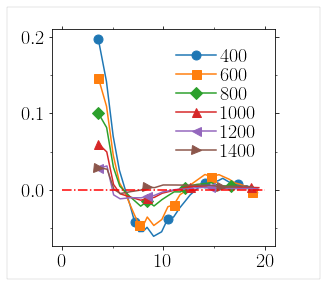

[400.           6.70001011]
[600.           6.18069832]
[800.          6.7058975]
[1000.            5.72860041]
[1200.            5.09059992]
[1400.            5.75247107]


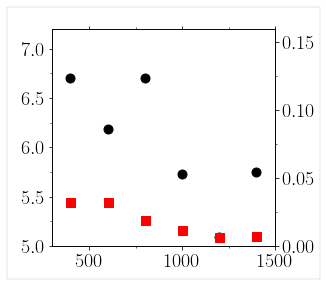

In [108]:
if eval(confParser['flags']['SroParameter']) and not\
   eval(confParser['flags']['RemoteMachine']):
    #--- plot order parameter vs. distance
    attrs = {'markevery':6,'markersize':9}
    path = '/Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess' #--- path
    ymeans = {}
    for temp, count in zip([400,600,800,1000,1200,1400],range(100)): #--- T
        pathh = path+'/NiCoCrNatom100KTemp%ssro/Run0/orderParameter/deltap_r_ij_index0.txt'%temp
        print('parse from %s'%pathh)
        try:
            sarray = np.loadtxt(pathh)
            #--- filter
            filtr = ~np.isnan(sarray[:,1])
            #--- order parameter
            sdata = sarray[filtr]
            xdata = sdata[:,0][1:]
            ydata = sdata[:,1][1:]
            #--- mean y
            filtr = ydata > 0.0
            ymean = np.mean(ydata[filtr])
            ymeans[temp]=ymean
            #--- plot
            kwargs = {} if count == 0 else {'ax':ax}
            ax = utl.PltErr(xdata,ydata,
                        Plot=False,
                        **attrs,
                        label=r'$%s$'%temp,
                        **kwargs)

        except:
            continue
            
    #--- plot
    utl.PltErr([0,cutoff],[0,0],
                attrs={'fmt':'-.r'},
                ax=ax,
                Plot=True,
                title='orderParameter/wc_diff_sheng.png',
               legend=True,
#               ylim=[-0.2,0.2],
            DrawFrame=[0.2,0.2,0.15,0.1,0.1],
            )

    
    #--- plot lengthscale vs. temperature
    for temp, count in zip([400,600,800,1000,1200,1400],range(100)):
        pathh = path+'/NiCoCrNatom100KTemp%ssro/Run0/orderParameter/sroSize_ij_index0.txt'%temp
        try:
            sarray = np.loadtxt(pathh)
            #--- filter
            xdata = sarray       
            print(xdata)
            kwargs = {} if count == 0 else {'ax':ax}
            ax = utl.PltErr(xdata[0],xdata[1],
                        Plot=False,
                        attrs={'markersize':9,'color':'black','fmt':'o'},
                        ylim=(5,7.2),
                        xlim=(300,1500),
                        **kwargs)

        except:
            continue

            
    utl.PltErr(list(ymeans.keys()),list(map(ymeans.get,ymeans.keys())),
                Plot=False,
                attrs={'markersize':9,'color':'red','fmt':'s'},
                ylim=(0,0.16),
                xlim=(300,1500),
                twinx=True,
                ax=ax,
                DrawFrame=[0.2,0.2,0.15,0.1,0.1],
                title='orderParameter/sroSize_sheng.png',
              )


# Dislocations
## load line coordinates

In [89]:
def shift(atomm,lx):
    xc=atomm.x[0]
    atomm.x -= xc
    negative_shift = atomm.x >= 0.5*lx
    positive_shift = atomm.x < -0.5*lx
    assert not np.all([np.any(negative_shift),np.any(positive_shift)])
    atomm.x -= negative_shift * lx
    atomm.x += positive_shift * lx
    atomm.x += xc
    return np.any(negative_shift), np.any(positive_shift)
        
def GetVertexCoords(pathh,box,times,verbose=False):
    atomss = {}
    lx = box.CellVector[ 0, 0 ]
#    print(lx)
#    counter = 0
    for myfile in os.listdir(pathh): #--- multiple files
        #--- time step
        indd=myfile.find('.')
        timei=int(myfile[indd+1:])
        if verbose:
            print('file=',myfile)
            print('timei=',times[timei])
 
        #--- read file
        strr=open('%s/%s'%(pathh,myfile)).readlines() #--- read as string
        li = strr.index('DISLOCATIONS 2\n') #--- 1st line to be read
        if verbose:
            print('read line %s '%li)
        li += 1
        
        atomss[times[timei]] = {}
        tmp = {}
        for ii in range(2): #--- two dislocations
            dislocation_id = int(strr[li])
            if verbose:
                print('dislocation_id=',dislocation_id)
            #
            li += 3
            n_vertices = int(strr[li]) #--- # of lines
            if verbose:
                print('n_vertices=',n_vertices)
            #
            li+=1
            vertice_xyz=np.c_[list(map(lambda x: x.rsplit(sep=' ')[:3],strr[li:li+n_vertices]))].astype(float)
            li+=n_vertices
            #--- wrap
            tmp[ii]=lp.Atoms(x=vertice_xyz[:,0],
                                             y=vertice_xyz[:,1],
                                             z=vertice_xyz[:,2]
            )
        
            wrap = lp.Wrap(tmp[ii],box)
            wrap.WrapCoord()
            wrap.Set( tmp[ii] )
            wrap = lp.Wrap(tmp[ii],box)
            assert np.all(wrap.isInside()), 'aotms outside original box!'    
        #--- shift      
#        xmean0=np.mean(tmp[0].x)
        negative_shift, positive_shift = shift(tmp[0],lx)
#        if negative_shift or positive_shift:
#           print('shift',np.mean(tmp[0].x),xmean0,times[timei])

#        xmean1=np.mean(tmp[1].x)
        negative_shift, positive_shift = shift(tmp[1],lx)
#        if negative_shift or positive_shift:
#           print('shift',np.mean(tmp[1].x),xmean1,times[timei])

        #--- shift disl.0 or disl.1
        if np.mean(tmp[1].x)-np.mean(tmp[0].x) < -0.5*lx:
            tmp[1].x += lx
        elif np.mean(tmp[1].x)-np.mean(tmp[0].x) > 0.5*lx:
            tmp[1].x -= lx

        #--- front:0 rear: 1
        front = 1
        behind = 0
        if np.mean(tmp[0].x) - np.mean(tmp[1].x) > 0.0:
            front = 0
            behind = 1
        tmp_front = tmp[front]
        tmp_behind = tmp[behind]

        tmp[0] = tmp_front
        tmp[1] = tmp_behind
            
        
        
        atomss[times[timei]][0] = tmp[0]
        atomss[times[timei]][1] = tmp[1]
#        counter += 1
            
    return atomss

if eval(confParser['flags']['DislocAnl']):
    #--- make directory
    try:
        os.system('rm -r dislocations')
    except:
        pass
    !mkdir dislocations
    #--- run ovitos
    path = confParser['input files']['path']
    indx = confParser['input files']['fileIndex']
    fileName = '%s/%s'%(path,confParser['input files']['filename'].split()[int(indx)])
    nevery = int(confParser['parameters']['nevery'])
    #
    !ovitos OvitosCna.py $fileName mydislocations $nevery 5
    !mv mydislocations.* dislocations
     #--- box
    lmpMyData = lp.ReadDumpFile( fileName ) 
    lmpMyData.GetCords( ncount = 1)
    box = lp.Box( BoxBounds = lmpMyData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ) )

    #--- load ca files: extract xyz
    times = list(lmpData.coord_atoms_broken.keys())
    times.sort()
    atomss = GetVertexCoords('./dislocations', box, times[::nevery], verbose=False) #--- dislocation segments
    
    #--- print
    timei=0
    idd=0 #--- dislocation id
    display(pd.DataFrame(atomss[timei][idd].__dict__))


InputFile= /Users/Home/Desktop/Tmp/txt/git/HeaDef/lammpsRuns/AmirData/shengAnnealed/Temp600/dislocated/Run0//dump.shearedge5k_Sheng5_anealed_850load
num_frames= 2
frame=0
frame=1


,x,y,z
0,511.125000,91.815079,87.720653
1,510.691315,91.829666,88.452983
2,509.803986,91.841034,88.379756
3,509.397003,91.809136,89.115718
4,509.821991,91.796234,89.897121
...,...,...,...
217,511.951325,91.791718,86.217041
218,511.082001,91.794655,86.222740
219,510.691650,91.825668,86.985230
220,510.899231,91.474167,87.351517


## 3d map

In [77]:
# from mpl_toolkits import mplot3d

# for ii in atomss.keys():
#     fig = plt.figure()
#     ax = plt.axes(projection='3d')
#     xyz_data=np.c_[atomss[ii].x, atomss[ii].y, atomss[ii].z ]
    
#     zlo=xyz_data[:,2].min()
#     zhi=xyz_data[:,2].max()
#     dz=zhi-zlo
#     ymean=xyz_data[:,1].mean()
#     xmean=xyz_data[:,0].mean()

#     ax.set_zlim(zlo,zhi)
#     ax.set_ylim(ymean-0.5*dz,ymean+0.5*dz)
#     ax.set_xlim(xmean-0.5*dz,xmean+0.5*dz)


#     ax.plot3D(xyz_data[:,0],xyz_data[:,1],xyz_data[:,2] , 'black')
#     plt.show()

## height correlations

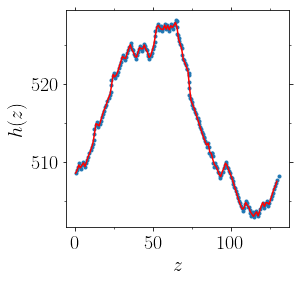

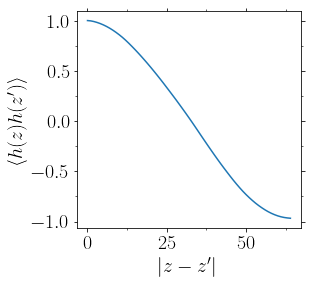

In [101]:
def interp(df,box,timei,verbose=False,Plot=True,**kwargs):
    x=df.z
    y=df.x
    #
    [xlo, xhi, junk]=box.BoxBounds[2].astype(float)
#    print(xlo,xhi)
    dx=1.0 #2*np.ceil(np.abs(np.diff(x)).min())
    hist, bin_edges = np.histogram(x,bins=np.arange(xlo,xhi,dx))
    ysum, bin_edges = np.histogram(x,bins=np.arange(xlo,xhi,dx),weights=y)
    ysum2, bin_edges = np.histogram(x,bins=np.arange(xlo,xhi,dx),weights=y*y)
    ymean = ysum / hist
    ysum2 /= hist
    ysum2 -= ymean*ymean
    ystd = (ysum2 / hist)**0.5
    bin_edges = (bin_edges[1:]+bin_edges[:-1])*0.5
    
    if Plot:
        if verbose:
            print('itime=',timei)
        if 'ax' in kwargs:
            ax = kwargs['ax']
            args = {'ax':ax}
            kwargs.pop('ax')
        else:
            args={}
        xx=0.5*(x.max()-x.min())
        
        ax=PltErr(x,y,
              attrs={'fmt':'.'},
                Plot=False,
                **args
              )
        ax=PltErr(bin_edges,ymean, #yerr=ystd,
              attrs={'fmt':'-r'},
               ax=ax,
#                ylim=(np.mean(y)-xx,np.mean(y)+xx),
#                xlim=(np.min(x),np.max(x)),
                Plot=False,
               **kwargs
              )
    
    return bin_edges, ymean, ystd


def Crltn(x,y):
    xq=np.fft.fft(x)
    yq=np.fft.fft(y)
    return np.fft.ifft(np.abs(xq*yq))/len(xq)

def PltCrltn(xint,yint, Plot = True,**kwargs):
#    print(yint.shape)
    crltn = Crltn(zscore(yint),zscore(yint))
    n = xint.shape[0]
    if Plot:
        PltErr((xint-xint[0])[0:int(n/2+n%2)],crltn[0:int(n/2+n%2)],
               attrs={'fmt':'-'},
               Plot = False,
               **kwargs)
    return (xint-xint[0])[0:int(n/2+n%2)],crltn[0:int(n/2+n%2)] #, xint[crltn<0][0]
        
if eval(confParser['flags']['DislocAnl']):

    zscore = lambda x: (x-np.mean(x))/np.std(x) 


    #--- interpolate h(z)
    xint, yint, junk = interp(atomss[timei][idd],box,timei,
                             xstr=r'$z$'    if not eval(confParser['flags']['RemoteMachine']) else 'z',
                             ystr=r'$h(z)$' if not eval(confParser['flags']['RemoteMachine']) else 'h(z)' ,
                             )

    #--- correlation
    junk,  junk =PltCrltn(xint,yint,
                                xstr=r'$|z-z^\prime|$' if not eval(confParser['flags']['RemoteMachine']) else 'dz',
                               ystr=r'$\langle h(z)h(z^\prime)\rangle$' if not eval(confParser['flags']['RemoteMachine']) else 'c(dz)',

                 )


### multiple timesteps

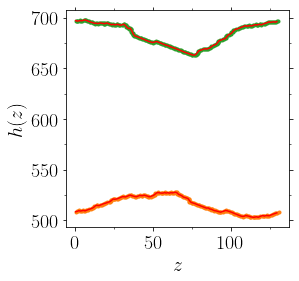

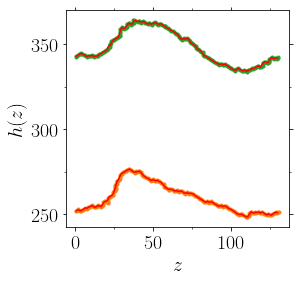

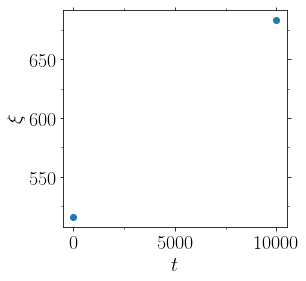

In [104]:
if eval(confParser['flags']['DislocAnl']):
    #--- timesteps
    times = list(atomss.keys())
    times.sort()
#    print(times)
    timei = times[0]
    idd=0
    
    #--- discretized x
    xint, junk, junk = interp(atomss[timei][idd],box,timei,Plot=False)

    #--- interpolate
    ax = PltErr(None,None,Plot=False)
    idd = 0 #--- dislocation id
    yint0 = np.c_[list(map(lambda x:interp(atomss[x][idd],box,x,Plot=True,ax=ax,                             
                                          xstr=r'$z$' if not eval(confParser['flags']['RemoteMachine']) else 'z',
                                          ystr=r'$h(z)$' if not eval(confParser['flags']['RemoteMachine']) else 'h(z)' ,
                                         )[1],times))]
    plt.show()
    #---
    ax = PltErr(None,None,Plot=False)
    idd = 1
    yint1 = np.c_[list(map(lambda x:interp(atomss[x][idd],box,x, Plot=True, ax=ax,                             
                                          xstr=r'$z$' if not eval(confParser['flags']['RemoteMachine']) else 'z',
                                          ystr=r'$h(z)$' if not eval(confParser['flags']['RemoteMachine']) else 'h(z)' ,
                                         )[1],times))]
    
    plt.show()
    #--- correlation
#     ax=PltErr(None,None,Plot=False)
#     junk = list(map(lambda x:PltCrltn(xint,x,ax=ax,
#                                      xstr=r'$|z-z^\prime|$' if not RemoteMachine else 'dz',
#                                      ystr=r'$\langle h(z)h(z^\prime)\rangle$' if not RemoteMachine else 'c(dz)',
#                                     ), yint0 ) )
#     plt.show()

#     #--- length
    PltErr(times[:30],np.mean(yint0,axis=1)[:30],
           attrs={'fmt':'o'},
           xstr=r'$t$' if not eval(confParser['flags']['RemoteMachine']) else 't',
           ystr=r'$\xi$' if not eval(confParser['flags']['RemoteMachine']) else 'ksi',
          )

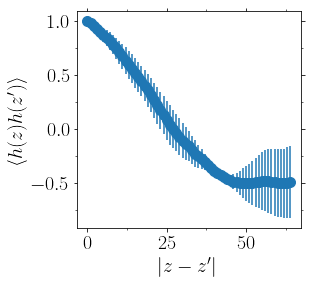

ksi_mean= 27.0


In [205]:
# if DislocAnl:
#     z = PltCrltn(xint,yint0[0],Plot=False)[0] #--- get data on the x-axis
#     cyy = np.c_[list(map(lambda x:PltCrltn(xint,x,Plot=False)[1],yint0))] #--- y-axis data: 



#     cmean = np.mean(cyy,axis=0)
#     erry = np.std(cyy,axis=0)/len(cyy)**0.5

#     PltErr(z,cmean,yerr=erry,
#              xstr=r'$|z-z^\prime|$' if not RemoteMachine else 'dz',
#              ystr=r'$\langle h(z)h(z^\prime)\rangle$') if not RemoteMachine else 'c(dz)',
#     print('ksi_mean=',z[cmean<0][0])
#     np.savetxt('dislocations/hcrltn.txt',np.c_[z,cmean.real,erry.real],header='z\th(z)\terr')
#     np.savetxt('dislocations/hlength.txt',np.c_[temperature,z[cmean.real<0][0]],header='temp\tksi')

## velocity correlations

h.shape= (2, 130)
v.shape= (1, 130)


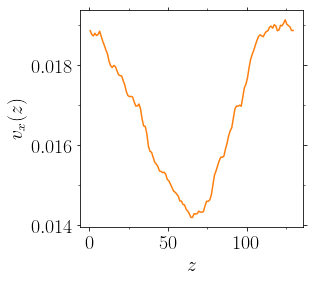

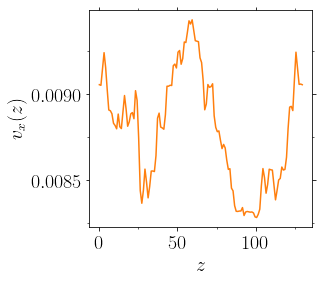

In [106]:
def minImage(v,box,verbose=False):
    lx = box.CellVector[ 0, 0 ]
    #--- minimum image
    v -= (np.mean(v) >= 0.5*lx) * lx
    v += (np.mean(v) < -0.5*lx) * lx
    return v

if eval(confParser['flags']['DislocAnl']):
    #--- velocity fluctuations
    print('h.shape=',yint0.shape)
#    vel0=np.diff((yint0.T-np.mean(yint0,axis=1)),axis=1).T
    vel0=np.diff((yint0.T),axis=1).T
    vel0=np.c_[list(map(lambda x:minImage(x,box),vel0))] #--- pbc
    dt = times[1]-times[0]
    vel0 /= dt
    #--- print
    header = 'r\t'+reduce(lambda x,y:x+y,map(lambda x: 'vx_%s\t'%x ,range(vel0.shape[0])))
    np.savetxt('dislocations/vx0_profile_multiple_times.txt',np.c_[xint,vel0.T],header=header)
    #
#    vel0=(vel0.T-np.mean(vel0,axis=1)).T #--- zero mean
#    vel0=(vel0.T/np.std(vel0,axis=1)).T  #--- unit variance
#    vel=np.c_[vel.T,1+vel[0,:]].T
    print('v.shape=',vel0.shape)
    
    
    #--- second dislocation
#    vel1=np.diff((yint1.T-np.mean(yint1,axis=1)),axis=1).T
    vel1=np.diff((yint1.T),axis=1).T
    vel1=np.c_[list(map(lambda x:minImage(x,box),vel1))] #--- pbc
    vel1 /= dt
    #--- print
    np.savetxt('dislocations/vx1_profile_multiple_times.txt',np.c_[xint,vel1.T],header=header)
    #
#    vel1=(vel1.T-np.mean(vel1,axis=1)).T
#    vel1=(vel1.T/np.std(vel1,axis=1)).T
    

    #--- plot
    ntime=vel0.shape[0]
    timei=0
    timef=ntime
    ax=PltErr(None,None,Plot=False)
    list(map(lambda x:PltErr(xint,x,ax=ax,
                             attrs={'fmt':'-'},
                             Plot=False,
                             xstr=r'$z$' if not eval(confParser['flags']['RemoteMachine']) else 'z',
                             ystr=r'$v_x(z)$' if not eval(confParser['flags']['RemoteMachine']) else 'vx(z)'),
             vel0[timei:timef]))
    plt.show()
    
    
    #--- plot 2nd dislocation
    ax=PltErr(None,None,Plot=False)
    list(map(lambda x:PltErr(xint,x,ax=ax,
                             attrs={'fmt':'-'},
                             Plot=False,
                             xstr=r'$z$' if not eval(confParser['flags']['RemoteMachine']) else 'z',
                             ystr=r'$v_x(z)$' if not eval(confParser['flags']['RemoteMachine']) else 'vx(z)'),
             vel1[timei:timef]))
    plt.show()

    
    

### multiple timesteps

### mean

z.shape= (22,)
cvv.shape= (1, 22)
cmean.shape= (22,)


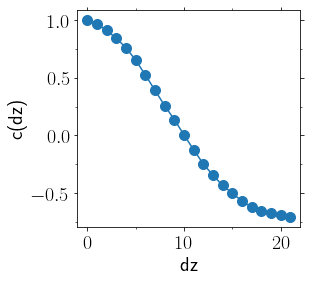

ksi_mean= 11.0


In [67]:
# if DislocAnl:
#     z = PltCrltn(xint,vel[0],Plot=False)[0]
#     print('z.shape=',z.shape)
#     cvv = np.c_[list(map(lambda x:PltCrltn(xint,x,Plot=False)[1],vel[timei:timef]))]
#     print('cvv.shape=',cvv.shape)
#     cmean = np.mean(cvv,axis=0)
#     print('cmean.shape=',cmean.shape)
#     erry = np.std(cvv,axis=0)/len(cvv)**0.5

#     PltErr(z,cmean,yerr=erry,
#              xstr=r'$|z-z^\prime|$' if not RemoteMachine else 'dz',
#              ystr=r'$\langle v_x(z).v_x(z^\prime)\rangle$' if not RemoteMachine else 'c(dz)')
#     print('ksi_mean=',z[cmean<0][0])
#     np.savetxt('dislocations/vxcrltn.txt',np.c_[z,cmean.real,erry.real],header='z\tv_x(z)\terr')
#     np.savetxt('dislocations/vxlength.txt',np.c_[temperature,z[cmean.real<0][0]],header='temp\tksi')

### Plot
#### velocity correlations

load=1100


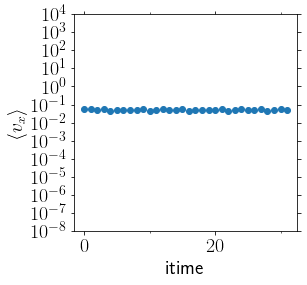

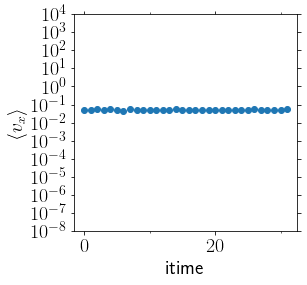

In [119]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    vx0_mean = {}
    vx1_mean = {}
    for load in [[1100],[500,600,650,700,750,800,900,950,1000,1100,1200,1300], #--- different loads
        {-3:400,
    -1:450,
    0:500,
    -2:550,
    1:600,
    2:650,
    3:700,
    4:750,}.values()][0]:

        print('load=%s'%load)
        pathh = ['dislocations',
                 'NiCoCrNatom100KTemp600/dislocated/load%s/Run0/dislocations'%load,
                 'NiCoCrNatom100Krss/dislocated/load%s/Run0/dislocations'%load][1]
        try:
            sdata0 = np.loadtxt('%s/vx0_profile_multiple_times.txt'%pathh) #--- velocity profile
            sdata1 = np.loadtxt('%s/vx1_profile_multiple_times.txt'%pathh) #--- velocity profile

            #--- fetch data
            r = sdata0[:,0]
            vx0 = sdata0[:,1:]
            vx1 = sdata1[:,1:]
            



            #--- mean velocity
            PltErr(np.arange(vx0.shape[1]),np.abs(np.mean(vx0,axis=0)),
                    attrs={'fmt':'.','markersize':12},
                    xstr=r'itime',
                    ystr=r'$\langle v_x \rangle$',
                    yscale='log',
                    ylim=(1e-8,1e4)
                    )     
        
            PltErr(np.arange(vx1.shape[1]),np.abs(np.mean(vx1,axis=0)),
                    attrs={'fmt':'.','markersize':12},
                    xstr=r'itime',
                    ystr=r'$\langle v_x \rangle$',
                    yscale='log',
                    ylim=(1e-8,1e4)
                    )

#             if load==750:
#                 vx0=vx0[:,20:]
#                 vx1=vx1[:,20:]

            
#             vx0=vx0[~np.isinf(vx0)]
#             vx1=vx1[~np.isinf(vx1)]
#             vx0=vx0[~np.isnan(vx0)]
#             vx1=vx1[~np.isnan(vx1)]
#             vx0=vx0[np.abs(vx0)>0]
#             vx1=vx1[np.abs(vx1)>0]

#             vx0_mean[load]=10**np.mean(np.log10(np.abs(vx0)))
#             vx1_mean[load]=10**np.mean(np.log10(np.abs(vx1)))
            
        

        except:
            traceback.print_exc()
            continue
            


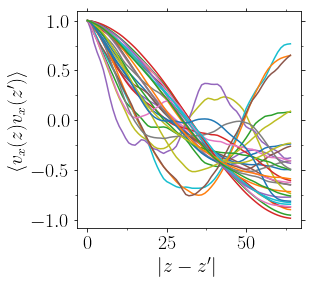

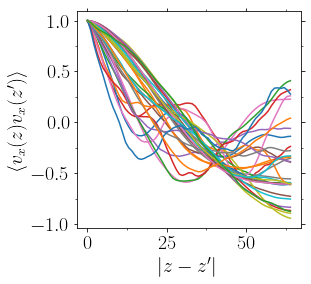

In [120]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    xint = r
    #--- correlation
    ax=PltErr(None,None,Plot=False)
    cvx0 = np.c_[list(map(lambda x:PltCrltn(xint,x,ax=ax,
                            xstr=r'$|z-z^\prime|$' if not eval(confParser['flags']['RemoteMachine']) else 'dz',
                               ystr=r'$\langle v_x(z)v_x(z^\prime)\rangle$' if not eval(confParser['flags']['RemoteMachine']) else 'c(dz)')[1].real,
             vx0.T))]
    plt.show()
    #--- 2nd dislocation
    ax=PltErr(None,None,Plot=False)
    cvx1 = np.c_[list(map(lambda x:PltCrltn(xint,x,ax=ax,
                            xstr=r'$|z-z^\prime|$' if not eval(confParser['flags']['RemoteMachine']) else 'dz',
                               ystr=r'$\langle v_x(z)v_x(z^\prime)\rangle$' if not eval(confParser['flags']['RemoteMachine']) else 'c(dz)')[1].real,
             vx1.T))]
    plt.show()

    
    #--- length
#     ksi0 = list(map(lambda x:PltCrltn(xint,x,ax=ax)[2],vel0[timei:timef]))
#     ksi1 = list(map(lambda x:PltCrltn(xint,x,ax=ax)[2],vel1[timei:timef]))
#     PltErr(times[:-1],ksi0,
#            attrs={'fmt':'o'},
#            xstr=r'$t$' if not RemoteMachine else 't',
#            ystr=r'$\xi$' if not RemoteMachine else 'ksi',
#           )
#     #--- 2nd dislocation
#     PltErr(times[:-1],ksi1,
#            attrs={'fmt':'o'},
#            xstr=r'$t$' if not RemoteMachine else 't',
#            ystr=r'$\xi$' if not RemoteMachine else 'ksi',
#           )
    
    #--- print cvx, ksi
#    n = xint.shape[0]
#    xarr = (xint-xint[0])[0:int(n/2+n%2)]
#    header = 'r\t'+reduce(lambda x,y:x+y,map(lambda x: 'vx_%s\t'%x ,range(cvx0.shape[0])))
#    np.savetxt('dislocations/vx0_crltn_multiple_times.txt',np.c_[xarr,cvx0.T],header=header)
#    np.savetxt('dislocations/vx0_length_multiple_times.txt',np.c_[times[:-1],ksi0],header='time\tksi')
    #---
#    np.savetxt('dislocations/vx1_crltn_multiple_times.txt',np.c_[xarr,cvx1.T],header=header)
#    np.savetxt('dislocations/vx1_length_multiple_times.txt',np.c_[times[:-1],ksi1],header='time\tksi')


<AxesSubplot:>

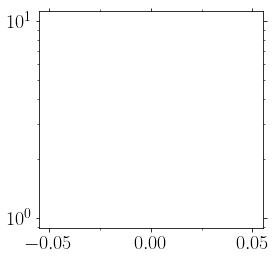

In [112]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    ax=PltErr(vx0_mean.keys(),list(map(lambda x:np.abs(vx0_mean[x]),vx0_mean.keys())),
           yscale='log',
            Plot=False
          )
    PltErr(vx1_mean.keys(),list(map(lambda x:np.abs(vx1_mean[x]),vx0_mean.keys())),
           yscale='log',
            Plot=False,
            ax=ax
          )

load=500


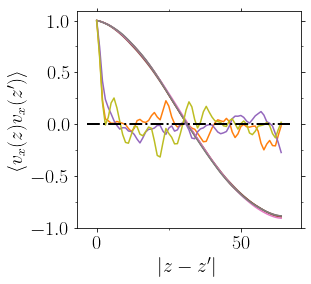

load=600


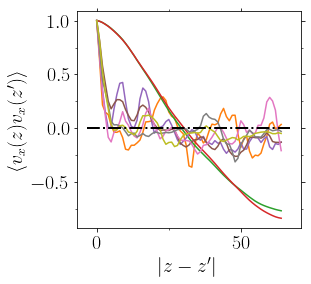

load=700


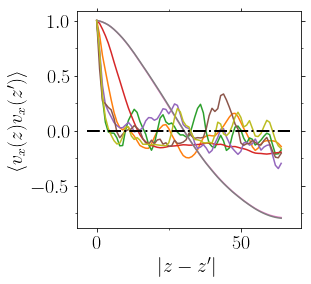

load=800


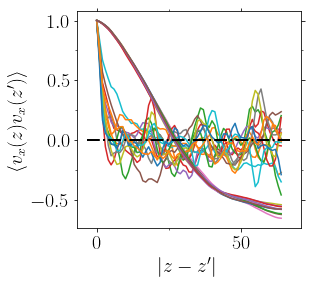

In [111]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    for load in ['500','600','700','800']: #--- different loads
        print('load=%s'%load)
        pathh = 'NiCoCrNatom100KTemp600/dislocated/load%s/Run0/dislocations'%load
        sdata = np.loadtxt('%s/vxcrltn_multiple_times.txt'%pathh)
        r = sdata[:,0]
        cvx = sdata[:,1:]

        #--- correlation
        ax=PltErr(None,None,Plot=False)
        list(map(lambda x:PltErr(r,x,ax=ax,
                                attrs={'fmt':'-'},
                                Plot=False,
                                ),
                 cvx.T))
        PltErr(ax.axis()[:2],[0,0],ax=ax,
               Plot=False,
                xstr=r'$|z-z^\prime|$',
                ystr=r'$\langle v_x(z)v_x(z^\prime)\rangle$',
               attrs={'fmt':'-.','color':'black','lw':2},
               title='dislocations/vxcrltn_%s.png'%load
              )
        plt.show()

#### lengthscale

load=500
load=600
load=700
load=800


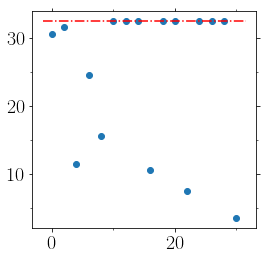

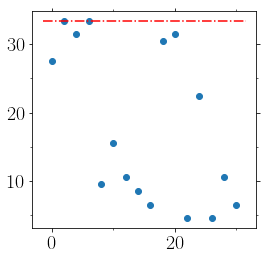

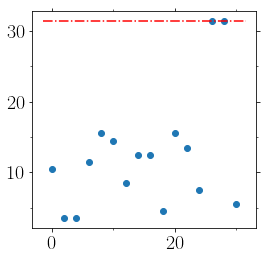

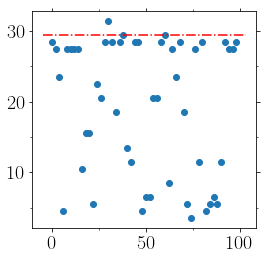

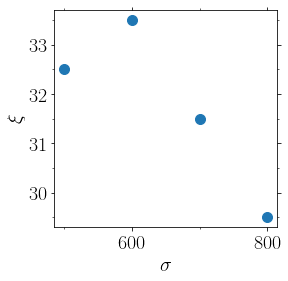

In [196]:
if eval(confParser['flags']['DislocAnl']) and not\
   eval(confParser['flags']['RemoteMachine']):
    ksii = {}
    for load in [500,600,700,800]:
        print('load=%s'%load)
        pathh = 'NiCoCrNatom100KTemp600/dislocated/load%s/Run0/dislocations'%load
        sdata = np.loadtxt('%s/vxlength_multiple_times.txt'%pathh)
        n=len(sdata)

        ax=PltErr(sdata[:,0],sdata[:,1],
           attrs={'fmt':'o'},
           xstr=r'$t$',
           ystr=r'$\xi$',
            Plot=False,
          )

        ksii[load]=utll.GetQuantile(pd.Series(sdata[:,1]),0.95)

        PltErr(ax.axis()[:2],[ksii[load],ksii[load]],
                attrs={'fmt':'-.r'},
               Plot=False,
               ax=ax
              )
        
    PltErr(ksii.keys(),list(map(lambda x:ksii[x],ksii.keys())),
#            attrs={'fmt':'-.r'},
           marker='o',
           fmt='.',
           Plot=True,
           xstr=r'$\sigma$',
           ystr=r'$\xi$',
           title='dislocations/xi.png',
          )
    
#RemoteMachine=False